# Group Level Network Analysis

In [1]:
from config import *
ds = '36p' # Denoising Strategy:
ct = 'partial' #Correlation Type
negative_corr = False
tm = 'gce' # Thresholding Method:
           # It could be 'GCE' or 'user_defined'
tv = 0.05  # Thresholding Value, For user defined tm

enodes_name = 'fisher'

### Import

In [2]:
from src.data import subjects
import src.group_level_analysis.group_level_analysis as gla
from src.viz import viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os
from IPython.display import display
import seaborn as sns
import random
import hoggorm as ho
import networkx as nx
from skbio.stats.distance import mantel

### Read Data

In [3]:
#all_sub_list = subjects.to_group_level_analysis[0]
all_sub_list = list(subjects.subjects['all']['participant_id'].values)
all_subjects = subjects.subjects['all'][subjects.subjects['all']['participant_id'].isin(all_sub_list)]

subjects_list = {}
for g in subjects_groups:
    subjects_list[g] = all_subjects.where(all_subjects.group==g).dropna()
    print('\n%d %s subjects are included'%(len(subjects_list[g]),g))
    display(subjects_list[g])
    subjects_list[g] = subjects_list[g].participant_id.tolist()


24 CN subjects are included


group participant_id sex   age
0     CN       003S4288   F  78.4
1     CN       011S0021   F  84.9
2     CN       020S6185   M  82.7
3     CN       023S1190   F  87.4
4     CN       035S6160   M  60.7
5     CN       036S6189   F  69.6
6     CN       037S4028   F  70.7
7     CN       041S4200   F  76.4
8     CN       041S6159   M  76.3
9     CN       041S6192   F  83.3
10    CN       094S4649   M  71.2
11    CN       114S0416   F  87.2
12    CN       114S6063   F  74.3
13    CN       116S6119   F  67.1
14    CN       168S6098   M  63.4
15    CN       168S6085   F  55.8
16    CN       168S6131   F  68.3
17    CN       941S6094   F  69.6
18    CN       116S4453   M  72.0
19    CN       033S4176   M  90.5
20    CN       002S4262   F  74.0
21    CN       002S4225   M  70.0
22    CN       031S4032   F  70.0
23    CN       018S4313   F  78.0


24 EMCI subjects are included


group participant_id sex   age
24  EMCI       012S4987   M  69.0
25  EMCI       002S4473   M  79.9
26  EMCI       011S4547   M  82.8
27  EMCI       011S4893   F  73.4
28  EMCI       012S4188   M  83.2
29  EMCI       014S2308   M  81.4
30  EMCI       037S4706   M  66.2
31  EMCI       041S4513   M  66.4
32  EMCI       041S4974   M  78.4
33  EMCI       068S2184   F  87.4
34  EMCI       068S2315   F  74.9
35  EMCI       068S4067   M  71.2
36  EMCI       068S4431   M  79.8
37  EMCI       082S2121   F  75.2
38  EMCI       094S2201   F  70.5
39  EMCI       094S2238   M  75.6
40  EMCI       002S2010   F  64.0
41  EMCI       002S4237   F  81.0
42  EMCI       002S2073   F  63.0
43  EMCI       002S4799   M  68.0
44  EMCI       002S2043   F  72.0
45  EMCI       137S4299   F  82.9
46  EMCI       137S4351   F  73.8
47  EMCI       137S4536   F  83.6


24 LMCI subjects are included


group participant_id sex   age
48  LMCI       002S4171   M  69.0
49  LMCI       002S4219   F  80.0
50  LMCI       002S4229   M  66.0
51  LMCI       002S4251   M  72.0
52  LMCI       002S4654   F  75.0
53  LMCI       002S4746   F  72.0
54  LMCI       003S4354   M  81.0
55  LMCI       006S4346   M  71.0
56  LMCI       006S4363   F  74.0
57  LMCI       006S4515   M  75.0
58  LMCI       006S4713   M  71.0
59  LMCI       006S4960   M  60.0
60  LMCI       012S4094   F  60.0
61  LMCI       013S4236   F  58.0
62  LMCI       013S4395   F  73.0
63  LMCI       035S4414   F  66.0
64  LMCI       036S4430   M  86.0
65  LMCI       036S4538   F  85.0
66  LMCI       036S4715   F  62.0
67  LMCI       037S4030   F  75.0
68  LMCI       037S4214   M  80.0
69  LMCI       041S4510   F  72.0
70  LMCI       068S4061   F  71.0
71  LMCI       941S4187   M  68.0


24 AD subjects are included


group participant_id sex   age
72    AD       002S5018   M  73.4
73    AD       006S4153   M  81.5
74    AD       006S4867   M  75.7
75    AD       013S5071   M  76.4
76    AD       018S4696   F  73.3
77    AD       018S4733   M  75.4
78    AD       018S5074   F  74.9
79    AD       019S4252   F  86.8
80    AD       019S4477   F  82.4
81    AD       019S4549   M  79.4
82    AD       019S5012   M  76.4
83    AD       053S5070   M  72.4
84    AD       053S5208   M  68.8
85    AD       100S5106   M  74.3
86    AD       130S4589   F  75.2
87    AD       130S4641   F  73.9
88    AD       130S4660   F  77.3
89    AD       130S4730   F  81.2
90    AD       130S4971   M  77.1
91    AD       130S4984   F  73.2
92    AD       130S4990   F  75.7
93    AD       130S5059   M  72.8
94    AD       130S5231   F  74.4
95    AD       136S4993   F  71.9

In [4]:
featuresDIR = rootdir + '/data/07_features/tm-%s/corr-%s/ds-%s'%(tm,ct,ds)
if enodes_name!='all':
    if negative_corr:
        Ntopdir = glob.glob(featuresDIR + '/*nodes-%s*negative*'%enodes_name)
        Ltopdir = glob.glob(featuresDIR + '/*links-%s*negative*'%enodes_name)

    else:
        Ntopdir = glob.glob(featuresDIR + '/*nodes-%s*positive*'%enodes_name)
        Ltopdir = glob.glob(featuresDIR + '/*links-%s*positive*'%enodes_name)
    if ct == 'glasso':
        Ntopdir = glob.glob(featuresDIR + '/*nodes-%s*'%enodes_name)
        Ltopdir = glob.glob(featuresDIR + '/*links-%s*'%enodes_name)

    lf = [int(i.split(enodes_name + '-')[1].split('_ds')[0]) for i in Ntopdir]
    print("""There are %d sets of features selected based of the %s algorithm. 
    The lengths of these sets are %s. select one of these sets:
    """%(len(lf),enodes_name,lf))
else:
    enodes = list(range(360))
    lf = [0]
    Ntopdir = []
    Ltopdir = glob.glob(featuresDIR + '/*links-%s*negative*'%"fisher")
    if ct == 'glasso':
        Ltopdir = glob.glob(featuresDIR + '/*links-%s*'%"fisher")

There are 2 sets of features selected based of the fisher algorithm. 
    The lengths of these sets are [57, 6]. select one of these sets:
    


In [5]:
selected_set = min(lf)

In [6]:
for i in Ntopdir:
    if int(i.split(enodes_name + '-')[1].split('_ds')[0])== selected_set:
        a = np.load(i)
        enodes = [e[0] for e in a]
        enodes = list(set(enodes))
        enodes.sort()
        break
snd= np.load(Ltopdir[0])

In [7]:
sg = subjects_groups.copy()
sg.append('all')
sg

['CN', 'EMCI', 'LMCI', 'AD', 'all']

In [8]:
str_loc    = ['loc_'  + ds for ds in denoising_strategies]
str_glob   = ['glob_' + ds for ds in denoising_strategies]
strlist    = str_loc.copy()
strlist.extend(str_glob)

In [9]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)
sgn = 'positive'
if negative_corr:
    sgn = 'negative'

In [10]:
norm = ""
if normalize_measures:
    norm="_norm"

directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/positive/tm-%s/corr-%s/ds-%s'%(rootdir,tm,ct,ds)
    if negative_corr:
        dirc = '%s/data/06_network_measures/negative/tm-%s/corr-%s/ds-%s'%(rootdir,tm,ct,ds)
    if ct=='glasso':
        if sign == 'both':
            dirc = '%s/data/06_network_measures/all/tm-/corr-%s/ds-%s'%(rootdir,ct,ds)
    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb] = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc]  = glob.glob("%s/*/*local_measures_giant_component%s.csv"%(dirc,norm))

In [11]:
measures = {}
measures['all'] = {}

for g in subjects_groups: 
    measures[g]  = {}

for i in strlist:
    measures['all'][str(i)] = {}
    for g in subjects_groups: 
        measures[g][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        measures['all'][str(i)][id] = pd.read_csv(sub, sep='\t')
        measures['all'][str(i)][id] = measures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        if 'loc' in str(i):
            measures['all'][str(i)][id] = measures['all'][str(i)][id].set_index('ID')
            if enodes_name!='all':
                measures['all'][str(i)][id] = measures['all'][str(i)][id].loc[enodes]
        for g in subjects_groups: 
            if id in subjects_list[g]:
                measures[g][str(i)][id] = pd.read_csv(sub, sep='\t')
                measures[g][str(i)][id] = measures[g][str(i)][id].drop(['Unnamed: 0'], axis=1)
                if 'loc' in str(i):
                    measures[g][str(i)][id] = measures[g][str(i)][id].set_index('ID')
                    if enodes_name!='all':
                        measures[g][str(i)][id] = measures[g][str(i)][id].loc[enodes]

In [12]:
directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/positive/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)
    if negative_corr:
        dirc = '%s/data/06_network_measures/negative/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)

    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb] = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc]  = glob.glob("%s/*/*local_measures_giant_component.csv"%(dirc))

In [13]:
RAWmeasures = {}
RAWmeasures['all'] = {}

for g in subjects_groups: 
    RAWmeasures[g]  = {}

for i in strlist:
    RAWmeasures['all'][str(i)] = {}
    for g in subjects_groups: 
        RAWmeasures[g][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        RAWmeasures['all'][str(i)][id]    = pd.read_csv(sub, sep='\t')
        RAWmeasures['all'][str(i)][id]    = RAWmeasures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        if 'loc' in str(i):
            RAWmeasures['all'][str(i)][id] = RAWmeasures['all'][str(i)][id].set_index('ID')
            if enodes_name!='all':
                RAWmeasures['all'][str(i)][id] = RAWmeasures['all'][str(i)][id].loc[enodes]
        for g in subjects_groups: 
            if id in subjects_list[g]:
                RAWmeasures[g][str(i)][id] = pd.read_csv(sub, sep='\t')
                RAWmeasures[g][str(i)][id] = RAWmeasures[g][str(i)][id].drop(['Unnamed: 0'], axis=1)
                if 'loc' in str(i):
                    RAWmeasures[g][str(i)][id] = RAWmeasures[g][str(i)][id].set_index('ID')
                    if enodes_name!='all':
                        RAWmeasures[g][str(i)][id] = RAWmeasures[g][str(i)][id].loc[enodes]

In [14]:
# measures variable structure:
#
#    measures
#    ├── group 1
#    │   ├── denoising strategy #1- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategy #1- local measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategy #2- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategy #2- local measures
#    │   │   └── group 1 subjects
#    │   ├── ...
#    │   └── denoising strategy #n- local measures
#    │       └── group 1 subjects
#    ├── ...
#    └── last group
#        ├── denoising strategy #1- global measures
#        │   └── last group subjects
#        ├── denoising strategy #1- local measures
#        │   └── last group subjects
#        ├── denoising strategy #2- global measures
#        │   └── last group subjects
#        ├── denoising strategy #2- local measures
#        │   └── last group subjects
#        ├── ...
#        └── denoising strategy #n- local measures
#            └── last group subject

In [15]:
print('Number of nodes appeared in the giant components of all subjects:\n') 
intersect = {}
for i in str_loc:
    intersect[i] = list(range(360))
    ll=360
    if enodes_name!='all':
        intersect[i] = enodes
        ll = len(enodes)
    for sub in measures['all'][i]:
        a = list(measures['all'][i][sub].index)
        intersect[i] = list(set(intersect[i]) & set(a))
    name = i.split('loc_')[1]
    print('\t%d out of %d nodes for networks with %s thresholding method.'
          %(len(intersect[i]),ll,name))

    #removing nodes
    for sub in measures['all'][i]:
        measures['all'][str(i)][sub] = measures['all'][str(i)][sub].loc[measures['all'][str(i)][sub].index.isin(intersect[i])]

Number of nodes appeared in the giant components of all subjects:

	6 out of 6 nodes for networks with 36p thresholding method.


### local measures mean and variance

In [16]:
# the mvfunc output structure:
#   
#         mvfunc(measures, sub_list, str_list)
#         │  
#         ├── mean
#         │   ├── denoising strategie 2- global measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 1- local measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 2- global measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 2- local measures
#         │   │   └─── subjects
#         │   ├── ...
#         │   │
#         │   ├── denoising strategie n- global measures
#         │   │   └─── subjects
#         │   └── denoising strategie n- local measures
#         │       └─── subjects
#         └── var
#             ├── denoising strategie 2- global measures
#             │   └─── subjects
#             ├── denoising strategie 1- local measures
#             │   └─── subjects
#             ├── denoising strategie 2- global measures
#             │   └─── subjects
#             ├── denoising strategie 2- local measures
#             │   └─── subjects
#             ├── ...
#             │
#             ├── denoising strategie n- global measures
#             │   └─── subjects
#             └── denoising strategie n- local measures
#                 └─── subjects

In [17]:
gla.mvfunc(measures['CN'],subjects_list['CN'], strlist)['mean']['loc_36p']

003S4288  011S0021  020S6185  023S1190  035S6160  \
degree                  0.619565  0.423280  0.529240  0.494444  0.523810   
eccentricity            1.000000  1.000000  1.000000  1.000000  1.000000   
betweenness             0.437399  0.170582  0.391628  0.264857  0.349899   
com_betweenness         0.483147  0.315401  0.381891  0.339957  0.420018   
eigenvector             0.606955  0.458367  0.523750  0.496637  0.551147   
katz                    0.471609  0.416122  0.452650  0.514637  0.496288   
closeness               0.829257  0.698503  0.800156  0.759941  0.783175   
current_flow_closeness  0.750698  0.628328  0.688601  0.690141  0.674491   
load                    0.442489  0.175492  0.395066  0.269082  0.353072   
clustering_coef         0.150663  0.194618  0.095641  0.183195  0.110479   
pagerank                0.609777  0.410391  0.520886  0.490478  0.522827   
subgraph                0.454579  0.287897  0.348361  0.308482  0.391444   
harmonic                0.798220  0.629902  0.730573  0.705910  0.730811   
strength                0.591241  0.534448  0.508481  0.454698  0.660164   

                        036S6189  037S4028  041S4200  041S6159  041S6192  ...  \
degree                  0.575472  0.556410  0.605072  0.657895  0.426282  ...   
eccentricity            0.000000  0.500000  0.000000  0.833333  1.000000  ...   
betweenness             0.295403  0.335941  0.336125  0.407297  0.279683  ...   
com_betweenness         0.389101  0.367194  0.407110  0.494877  0.284189  ...   
eigenvector             0.554670  0.548811  0.572527  0.638961  0.417188  ...   
katz                    0.396915  0.375019  0.424007  0.441105  0.500904  ...   
closeness               0.830154  0.837530  0.792801  0.866265  0.704957  ...   
current_flow_closeness  0.763556  0.768221  0.793247  0.813532  0.579423  ...   
load                    0.308606  0.339865  0.343532  0.409519  0.281503  ...   
clustering_coef         0.083954  0.053068  0.250504  0.169094  0.189151  ...   
pagerank                0.574039  0.554966  0.611519  0.656232  0.424334  ...   
subgraph                0.357112  0.330411  0.375004  0.463545  0.260862  ...   
harmonic                0.790476  0.790287  0.789698  0.821695  0.631730  ...   
strength                0.454832  0.562718  0.610406  0.550764  0.450713  ...   

                        168S6098  168S6085  168S6131  941S6094  116S4453  \
degree                  0.535714  0.543860  0.445578  0.528736  0.527273   
eccentricity            0.500000  0.000000  0.000000  1.000000  0.000000   
betweenness             0.320755  0.288532  0.237231  0.283565  0.316125   
com_betweenness         0.399060  0.369965  0.281567  0.365089  0.346894   
eigenvector             0.553628  0.541216  0.431475  0.511766  0.507927   
katz                    0.620900  0.549542  0.295239  0.526440  0.378937   
closeness               0.806157  0.813192  0.674317  0.786882  0.790976   
current_flow_closeness  0.729358  0.765200  0.645729  0.715104  0.710449   
load                    0.325993  0.299357  0.243943  0.287582  0.318220   
clustering_coef         0.127928  0.129513  0.338775  0.121290  0.445204   
pagerank                0.527841  0.539938  0.437930  0.527198  0.527633   
subgraph                0.372624  0.342055  0.254566  0.338833  0.323756   
harmonic                0.762740  0.783333  0.652422  0.729587  0.762353   
strength                0.457162  0.573317  0.554724  0.536093  0.594021   

                        033S4176  002S4262  002S4225  031S4032  018S4313  
degree                  0.442177  0.463470  0.534826  0.429224  0.438172  
eccentricity            0.000000  0.833333  1.000000  1.000000  1.000000  
betweenness             0.265624  0.245384  0.304988  0.247024  0.209851  
com_betweenness         0.267480  0.355505  0.412828  0.299169  0.279677  
eigenvector             0.417561  0.493692  0.560124  0.435089  0.420682  
katz                    0.452210  0.218713  0.416459  0.436241  0.557467  
c

the mean and the variance of centerality measures of all nodes in all adjacency matrices of subjects from a specific group

In [18]:
gla.mvfunc_total(measures,sg,strlist,ds)

CN_mean    CN_var  EMCI_mean  EMCI_var  LMCI_mean  \
degree                  0.516435  0.034620   0.512401  0.034820   0.466139   
eccentricity            0.694444  0.192696   0.545139  0.230466   0.444444   
betweenness             0.300761  0.035124   0.292052  0.033819   0.253005   
com_betweenness         0.368260  0.043033   0.359230  0.041051   0.325993   
eigenvector             0.516468  0.035386   0.512842  0.036531   0.474877   
katz                    0.452939  0.033279   0.473118  0.023891   0.527321   
closeness               0.769544  0.015877   0.766110  0.021140   0.720021   
current_flow_closeness  0.700141  0.023864   0.705645  0.026028   0.671511   
load                    0.305365  0.035001   0.295772  0.033767   0.257731   
clustering_coef         0.193470  0.016219   0.188342  0.014655   0.197543   
pagerank                0.513359  0.034034   0.507853  0.034351   0.462316   
subgraph                0.338080  0.041461   0.328637  0.038882   0.297063   
harmonic                0.717574  0.018321   0.716877  0.023726   0.677580   
strength                0.538215  0.025491   0.459424  0.031040   0.454808   

                        LMCI_var   AD_mean    AD_var  all_mean   all_var  
degree                  0.040487  0.378797  0.046667  0.468443  0.042019  
eccentricity            0.227661  0.763889  0.181624  0.611979  0.222656  
betweenness             0.033087  0.188020  0.031208  0.258460  0.035117  
com_betweenness         0.044164  0.246061  0.043654  0.324886  0.045074  
eigenvector             0.041747  0.384866  0.047410  0.472263  0.042875  
katz                    0.023464  0.510588  0.027143  0.490992  0.027673  
closeness               0.026333  0.646604  0.040807  0.725570  0.028369  
current_flow_closeness  0.034428  0.585159  0.048591  0.665614  0.035384  
load                    0.032996  0.191754  0.031439  0.262656  0.035124  
clustering_coef         0.013424  0.207499  0.026443  0.196714  0.017642  
pagerank                0.040116  0.376506  0.046095  0.465008  0.041456  
subgraph                0.040983  0.219959  0.038988  0.295935  0.042028  
harmonic                0.026585  0.593851  0.038064  0.676471  0.029077  
strength                0.030774  0.380677  0.030637  0.458281  0.032444

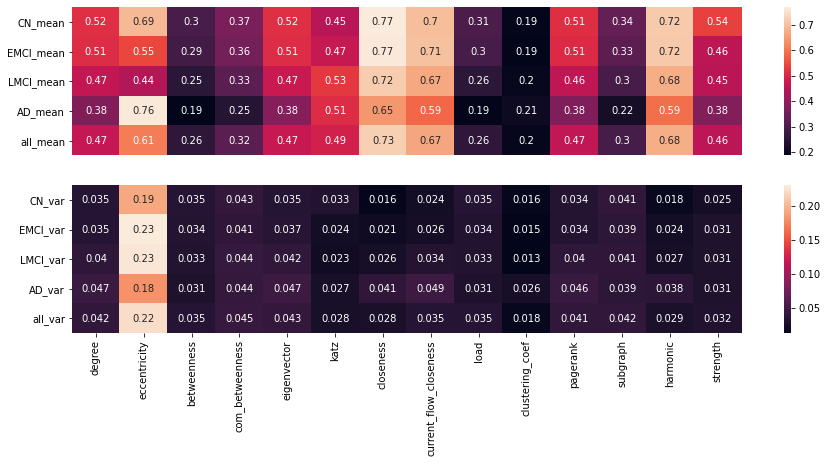

In [19]:
plt.figure(figsize=(15,6))

plt.subplot(211)
sns.heatmap(gla.mvfunc_total(measures,sg,strlist,ds).T.
            iloc[[2*i for i in range(int(len(subjects_groups)/2)*2+1)]],
            annot=True, xticklabels=False)
plt.subplot(212)

sns.heatmap(gla.mvfunc_total(measures,sg,strlist,ds).T.
            iloc[[2*i+1 for i in range(int(len(subjects_groups)/2)*2+1)]],
            annot=True)
plt.show()

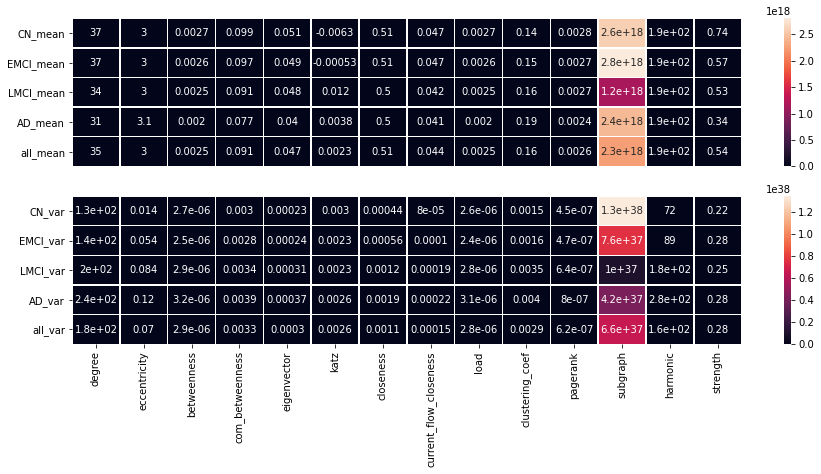

In [20]:
plt.figure(figsize=(15,6))

plt.subplot(211)
sns.heatmap(gla.mvfunc_total(RAWmeasures,sg,strlist,ds).T.
            iloc[[2*i for i in range(int(len(subjects_groups)/2)*2+1)]],
            annot=True, xticklabels=False,linewidths=.5, linecolor='white')
plt.subplot(212)

sns.heatmap(gla.mvfunc_total(RAWmeasures,sg,strlist,ds).T.
            iloc[[2*i+1 for i in range(int(len(subjects_groups)/2)*2+1)]],
            annot=True,linewidths=.5, linecolor='white')
plt.show()

### Histogram of  raw measures

In [21]:
total_RAWmeasures={}
total_RAWmeasures['all'] ={}

for i in all_subjects.index:
    try:
        total_RAWmeasures[all_subjects.iloc[i]['group']]=pd.concat([total_RAWmeasures[all_subjects.iloc[i]['group']],RAWmeasures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]])
        total_RAWmeasures['all']= pd.concat([total_RAWmeasures['all'],RAWmeasures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]])
        
    except:
        total_RAWmeasures[all_subjects.iloc[i]['group']]=RAWmeasures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]
        if pd.DataFrame(total_RAWmeasures['all']).empty:
            total_RAWmeasures['all']=RAWmeasures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]


Histogram of degree


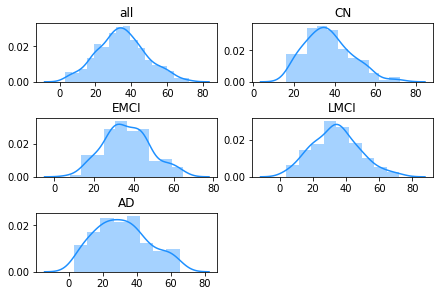


Histogram of eccentricity


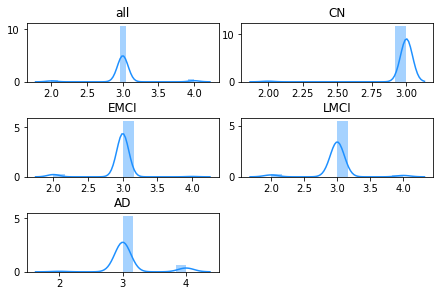


Histogram of betweenness


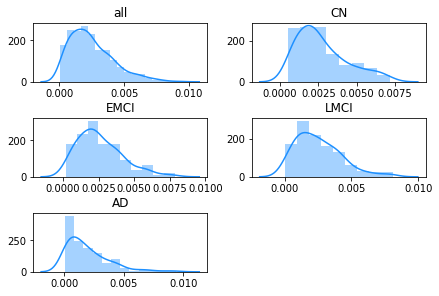


Histogram of com_betweenness


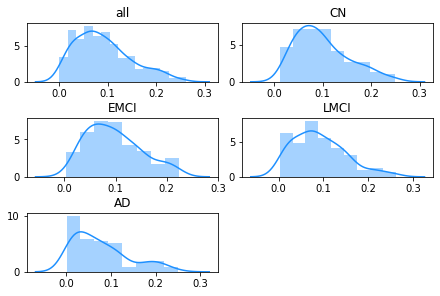


Histogram of eigenvector


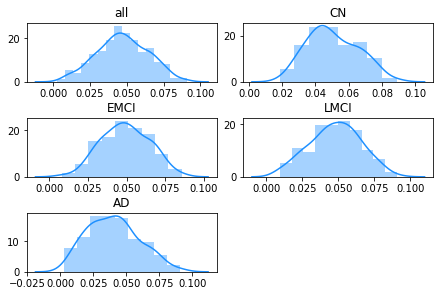


Histogram of katz


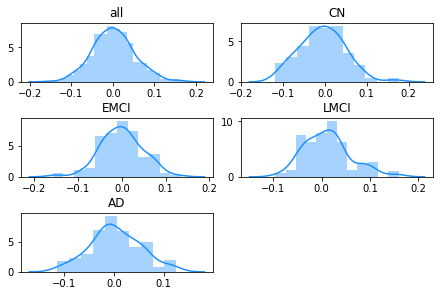


Histogram of closeness


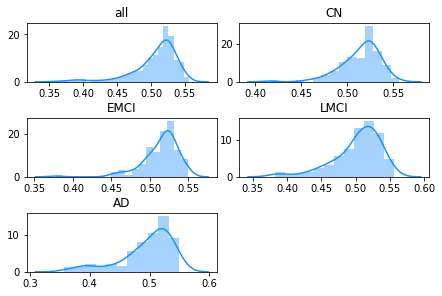


Histogram of current_flow_closeness


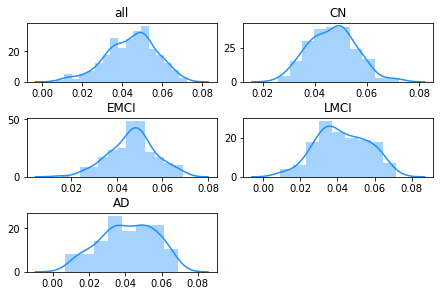


Histogram of load


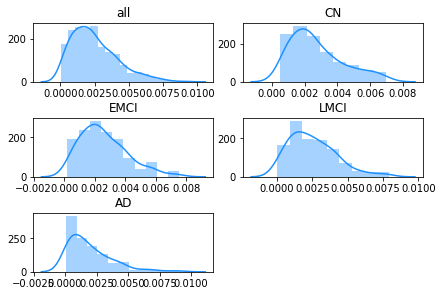


Histogram of clustering_coef


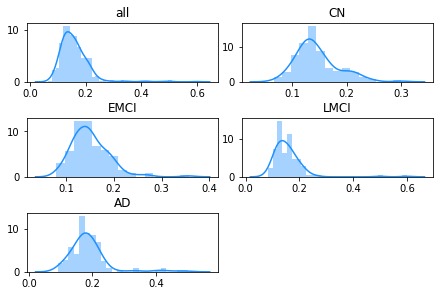


Histogram of pagerank


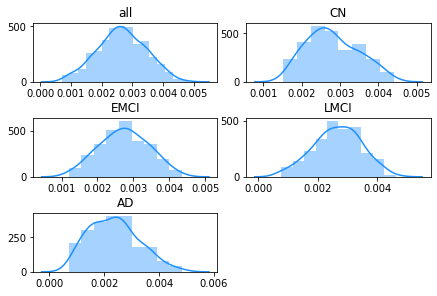


Histogram of subgraph


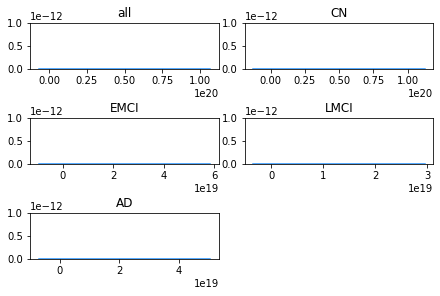


Histogram of harmonic


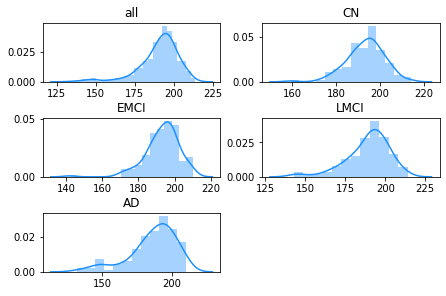


Histogram of strength


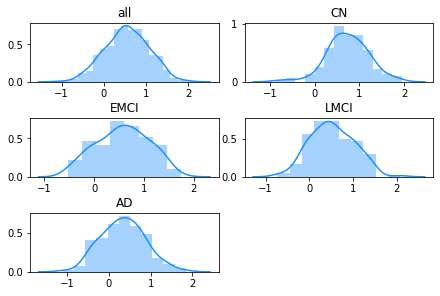

In [22]:
#plt.figure(figsize=(12,15))
mes = total_RAWmeasures['all'].T.index
for j in range(len(mes)):
    print('\nHistogram of %s'%mes[j])
    for i in range(len(total_RAWmeasures.keys())):
        g = list(total_RAWmeasures.keys())[i]
        plt.subplot(int((len(total_RAWmeasures.keys())+1)/2),2,i+1)
        sns.distplot(total_RAWmeasures[g][mes[j]].values, color="dodgerblue", label="Compact")
        plt.title(g)
    plt.tight_layout(pad=.3)
    plt.show()

### Histogram of MinMax normalized measures

In [23]:
total_measures={}
total_measures['all'] ={}

for i in all_subjects.index:
    try:
        total_measures[all_subjects.iloc[i]['group']]=pd.concat([total_measures[all_subjects.iloc[i]['group']],measures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]])
        total_measures['all']= pd.concat([total_measures['all'],measures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]])
        
    except :
        total_measures[all_subjects.iloc[i]['group']]=measures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]
        if pd.DataFrame(total_measures['all']).empty:
            total_measures['all']=measures['all'][str_loc[0]][all_subjects.iloc[i]['participant_id']]


Histogram of degree


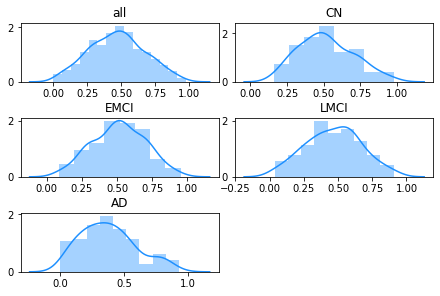


Histogram of eccentricity


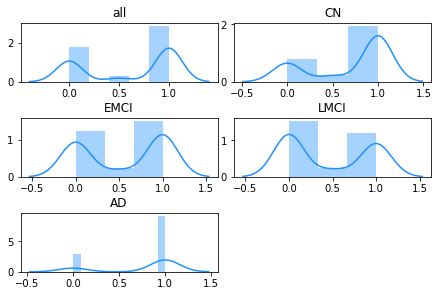


Histogram of betweenness


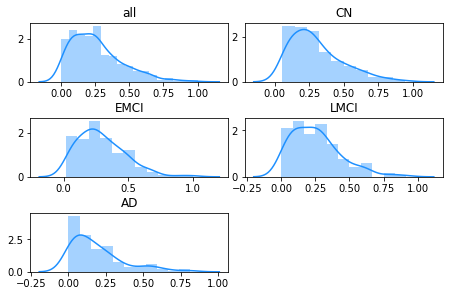


Histogram of com_betweenness


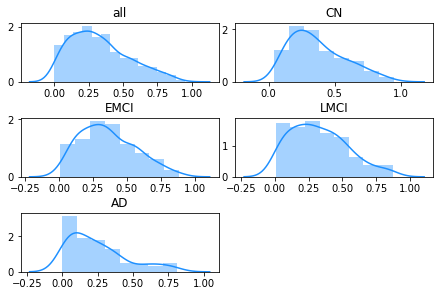


Histogram of eigenvector


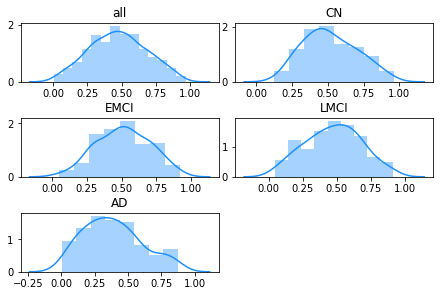


Histogram of katz


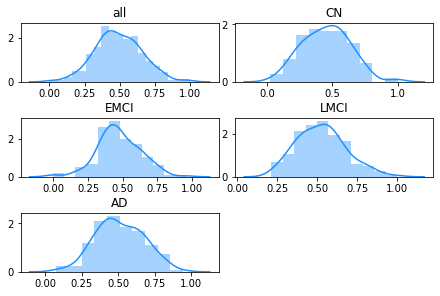


Histogram of closeness


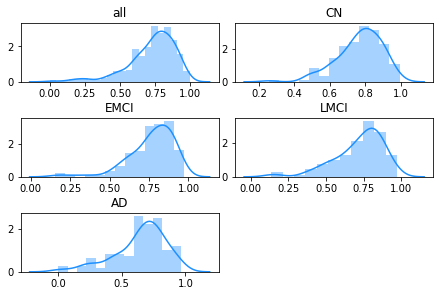


Histogram of current_flow_closeness


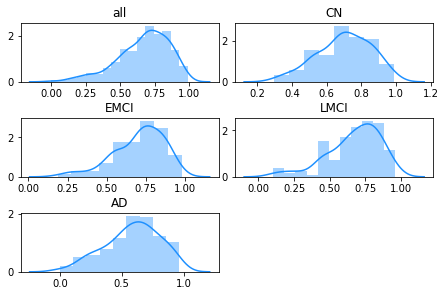


Histogram of load


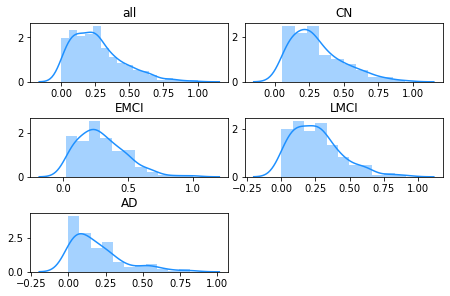


Histogram of clustering_coef


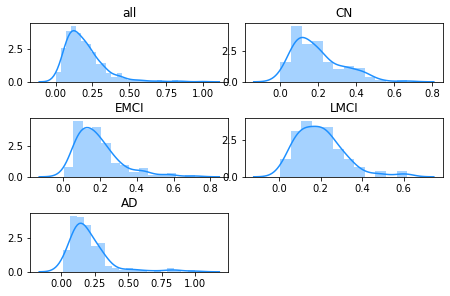


Histogram of pagerank


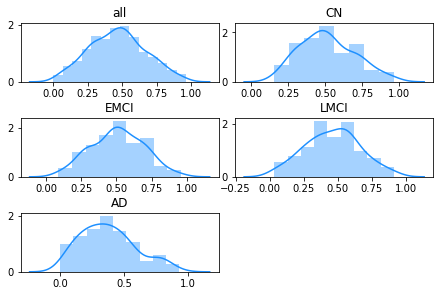


Histogram of subgraph


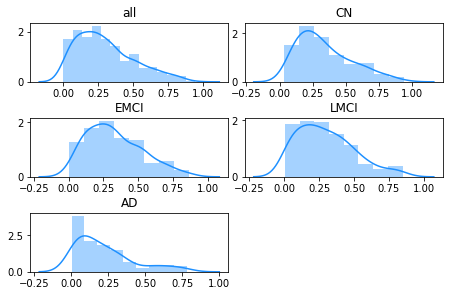


Histogram of harmonic


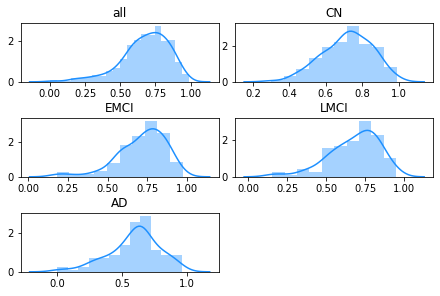


Histogram of strength


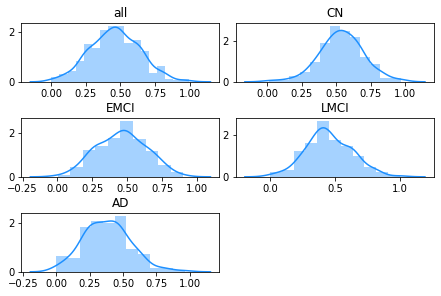

In [24]:
#plt.figure(figsize=(12,15))
mes = total_measures['all'].T.index
for j in range(len(mes)):
    print('\nHistogram of %s'%mes[j])
    for i in range(len(total_measures.keys())):
        g = list(total_measures.keys())[i]
        plt.subplot(int((len(total_measures.keys())+1)/2),2,i+1)
        sns.distplot(total_measures[g][mes[j]].values, color="dodgerblue", label="Compact")
        plt.title(g)
    plt.tight_layout(pad=.3)
    plt.show()

### Correlation between centraliry measures among members of each group

#### Correlation between centraliry measures among a random selection of members of each group
Splitting each group of subjects in half and rebuilding measures variable:

In [25]:
measures_h1 = dict()
measures_h2 = dict()
for g in subjects_groups:
    measures_h1[g] = dict()
    measures_h2[g] = dict()
    for sr in str_loc:
        main = list(measures[g][sr].keys())
        h1 = random.sample(main, k=int(len(main)/2))
        h2 = [s for s in main if s not in h1 and s ]
        measures_h1[g][sr] = dict()
        measures_h2[g][sr] = dict()

        for (key, value) in measures[g][sr].items():
            if key in h1:
                measures_h1[g][sr][key] = value
        for (key, value) in measures[g][sr].items():
            if key in h2:
                measures_h2[g][sr][key] = value

In [26]:
mes_rel    = gla.mes_rel(measures,sg,strlist,ds)
mes_rel_h1 = gla.mes_rel(measures_h1,subjects_groups,strlist,ds)
mes_rel_h2 = gla.mes_rel(measures_h2,subjects_groups,strlist,ds)

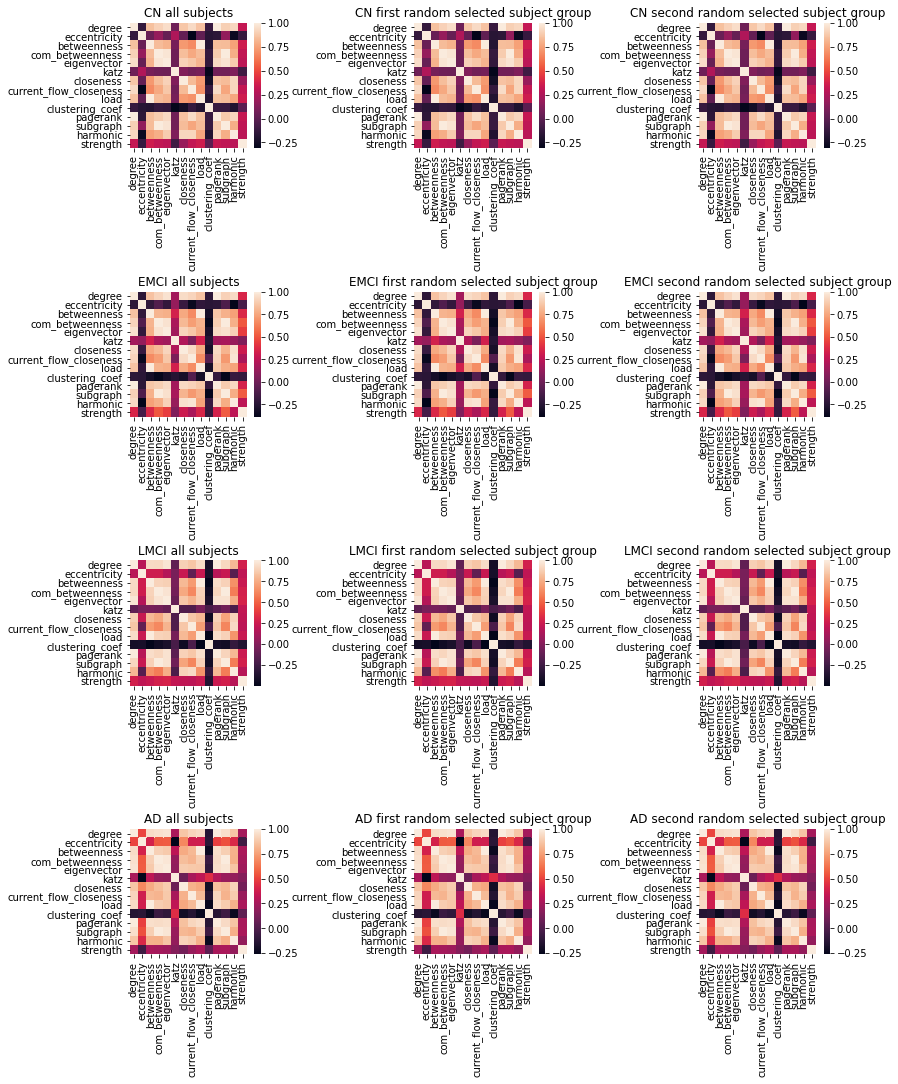

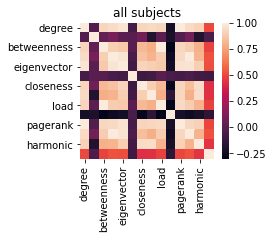

In [27]:
ff = plt.figure(figsize=(12,15))
ax = [ff.add_subplot((len(subjects_groups)),3,k+1) for k in range(3*len(subjects_groups))]
g =[]
for i in range(len(subjects_groups)):
    g.append(sns.heatmap(mes_rel['corr'][str_loc[0]][subjects_groups[i]],ax=ax[3*i]))
    ax[3*i].title.set_text('%s all subjects'%subjects_groups[i])
    
    g.append(sns.heatmap(mes_rel['corr'][str_loc[0]][subjects_groups[i]],ax=ax[3*i+1]))
    ax[3*i+1].title.set_text('%s first random selected subject group'%subjects_groups[i])

    g.append(sns.heatmap(mes_rel['corr'][str_loc[0]][subjects_groups[i]],ax=ax[3*i+2]))
    ax[3*i+2].title.set_text('%s second random selected subject group'%subjects_groups[i])
plt.tight_layout(pad=.5)

ff = plt.figure(figsize=(3,2.5))
ax = ff.add_subplot(1,1,1)
sns.heatmap(mes_rel['corr']['loc_36p']['all'],ax=ax)
ax.title.set_text("all subjects")

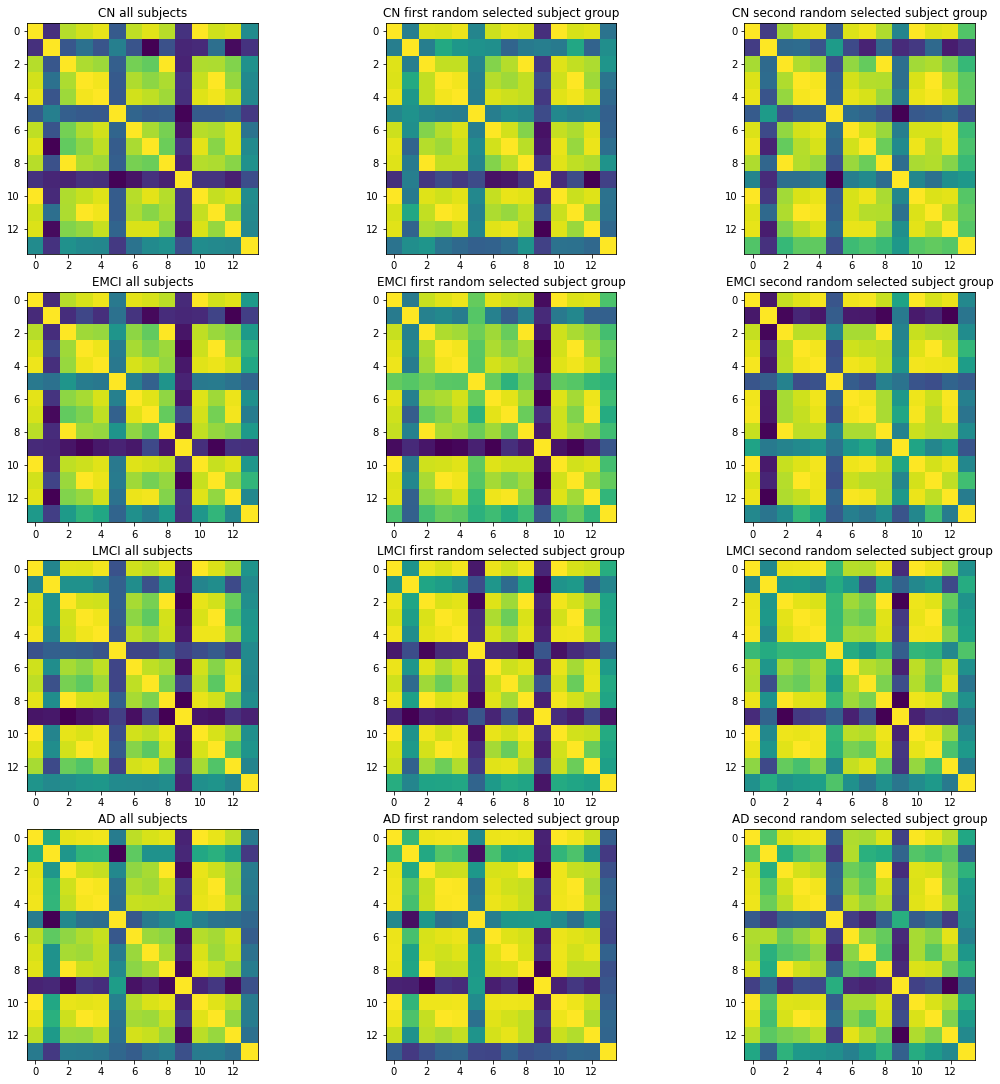

In [28]:
ff = plt.figure(figsize=(15,15))
ax = [ff.add_subplot((len(subjects_groups)),3,k+1) for k in range(3*len(subjects_groups))]
L = []
labels = []
for i in range(len(subjects_groups)):
    a = mes_rel['corr'][str_loc[0]][subjects_groups[i]]
    ax[3*i].imshow(a)
    ax[3*i].title.set_text('%s all subjects'%subjects_groups[i])
    L.append(a - np.mean(a))
    labels.append("all %s"%subjects_groups[i])
    
    a = mes_rel_h1['corr'][str_loc[0]][subjects_groups[i]]
    ax[3*i+1].imshow(a)
    ax[3*i+1].title.set_text('%s first random selected subject group'%subjects_groups[i])
    L.append(a - np.mean(a))
    labels.append("first subgroup of %s"%subjects_groups[i])

    a = mes_rel_h2['corr'][str_loc[0]][subjects_groups[i]]
    ax[3*i+2].imshow(a)
    ax[3*i+2].title.set_text('%s second random selected subject group'%subjects_groups[i])
    L.append(a - np.mean(a))
    labels.append("second subgroup of %s"%subjects_groups[i])

plt.tight_layout(pad=.5)

#### Correlation between these correlation matrices 

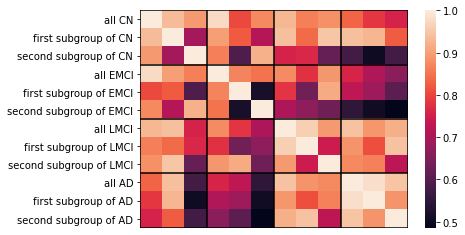

In [29]:
rv_results0 = ho.RVcoeff(L)

fig, ax = plt.subplots()         # Sample figsize in inches
ax = sns.heatmap(rv_results0,yticklabels=labels,xticklabels=False,ax=ax)
ax.hlines([3*i for i in range(len(subjects_groups)+1)], *ax.get_xlim())
ax.vlines([3*i for i in range(len(subjects_groups)+1)], *ax.get_xlim())

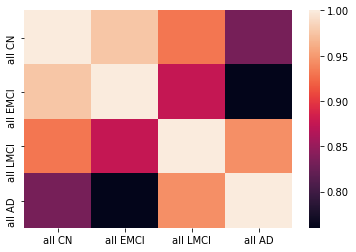

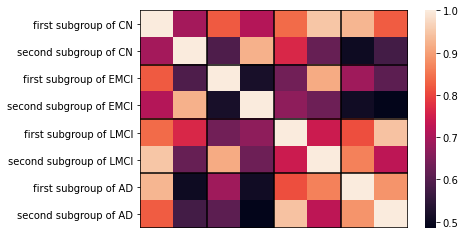

In [30]:
Lall = [L[3*i] for i in range(int(len(L)/3))]
labelsall = [labels[3*i] for i in range(int(len(L)/3))]
rv_results1 = ho.RVcoeff(Lall)
fig, ax = plt.subplots()         # Sample figsize in inches
ax = sns.heatmap(rv_results1,yticklabels=labelsall,xticklabels=labelsall,ax=ax)

Lh = []
for i in range(int(len(L)/3)):
    Lh.append(L[3*i+1])
    Lh.append(L[3*i+2])
labelsh = [i for i in labels if i not in labelsall]

rv_results1 = ho.RVcoeff(Lh)
fig, ax = plt.subplots()         # Sample figsize in inches
ax = sns.heatmap(rv_results1,yticklabels=labelsh,xticklabels=False,ax=ax)
ax.hlines([2*i for i in range(len(subjects_groups)+1)], *ax.get_xlim())
ax.vlines([2*i for i in range(len(subjects_groups)+1)], *ax.get_xlim())

### Correlation between subjects
list of subjects sorted based on their group:

In [31]:
cols = subjects_list[subjects_groups[0]].copy()
sep=[len(subjects_list[subjects_groups[0]])]
for i in range(1,len(subjects_groups)):
    cols.extend(subjects_list[subjects_groups[i]])
    sep.append(len(subjects_list[subjects_groups[i]]) + sep[i-1])
sep.insert(0,0)

#### Correlation based on centrality measures

###### Correlation based on each local centraliry measures for each subject.

In [32]:
mes = list(mes_rel['corr'][strlist[0]][subjects_groups[0]].index)    

In [33]:
mtx = {}
for m in mes:
    mtx[m] = {}
    for sr in str_loc:
        mtx[m][sr] = 0
        for s in cols:
            try:
                mtx[m][sr]=np.concatenate((mtx[m][sr], measures['all'][sr][s][m].values.reshape(len(measures['all'][sr][s][m]),1)),
                                   axis=1)
            except ValueError:
                mtx[m][sr]=measures['all'][sr][s][m].values.reshape(len(measures['all'][sr][s][m]),1)
    mtx[m][sr] = np.corrcoef(mtx[m][sr].T)  

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


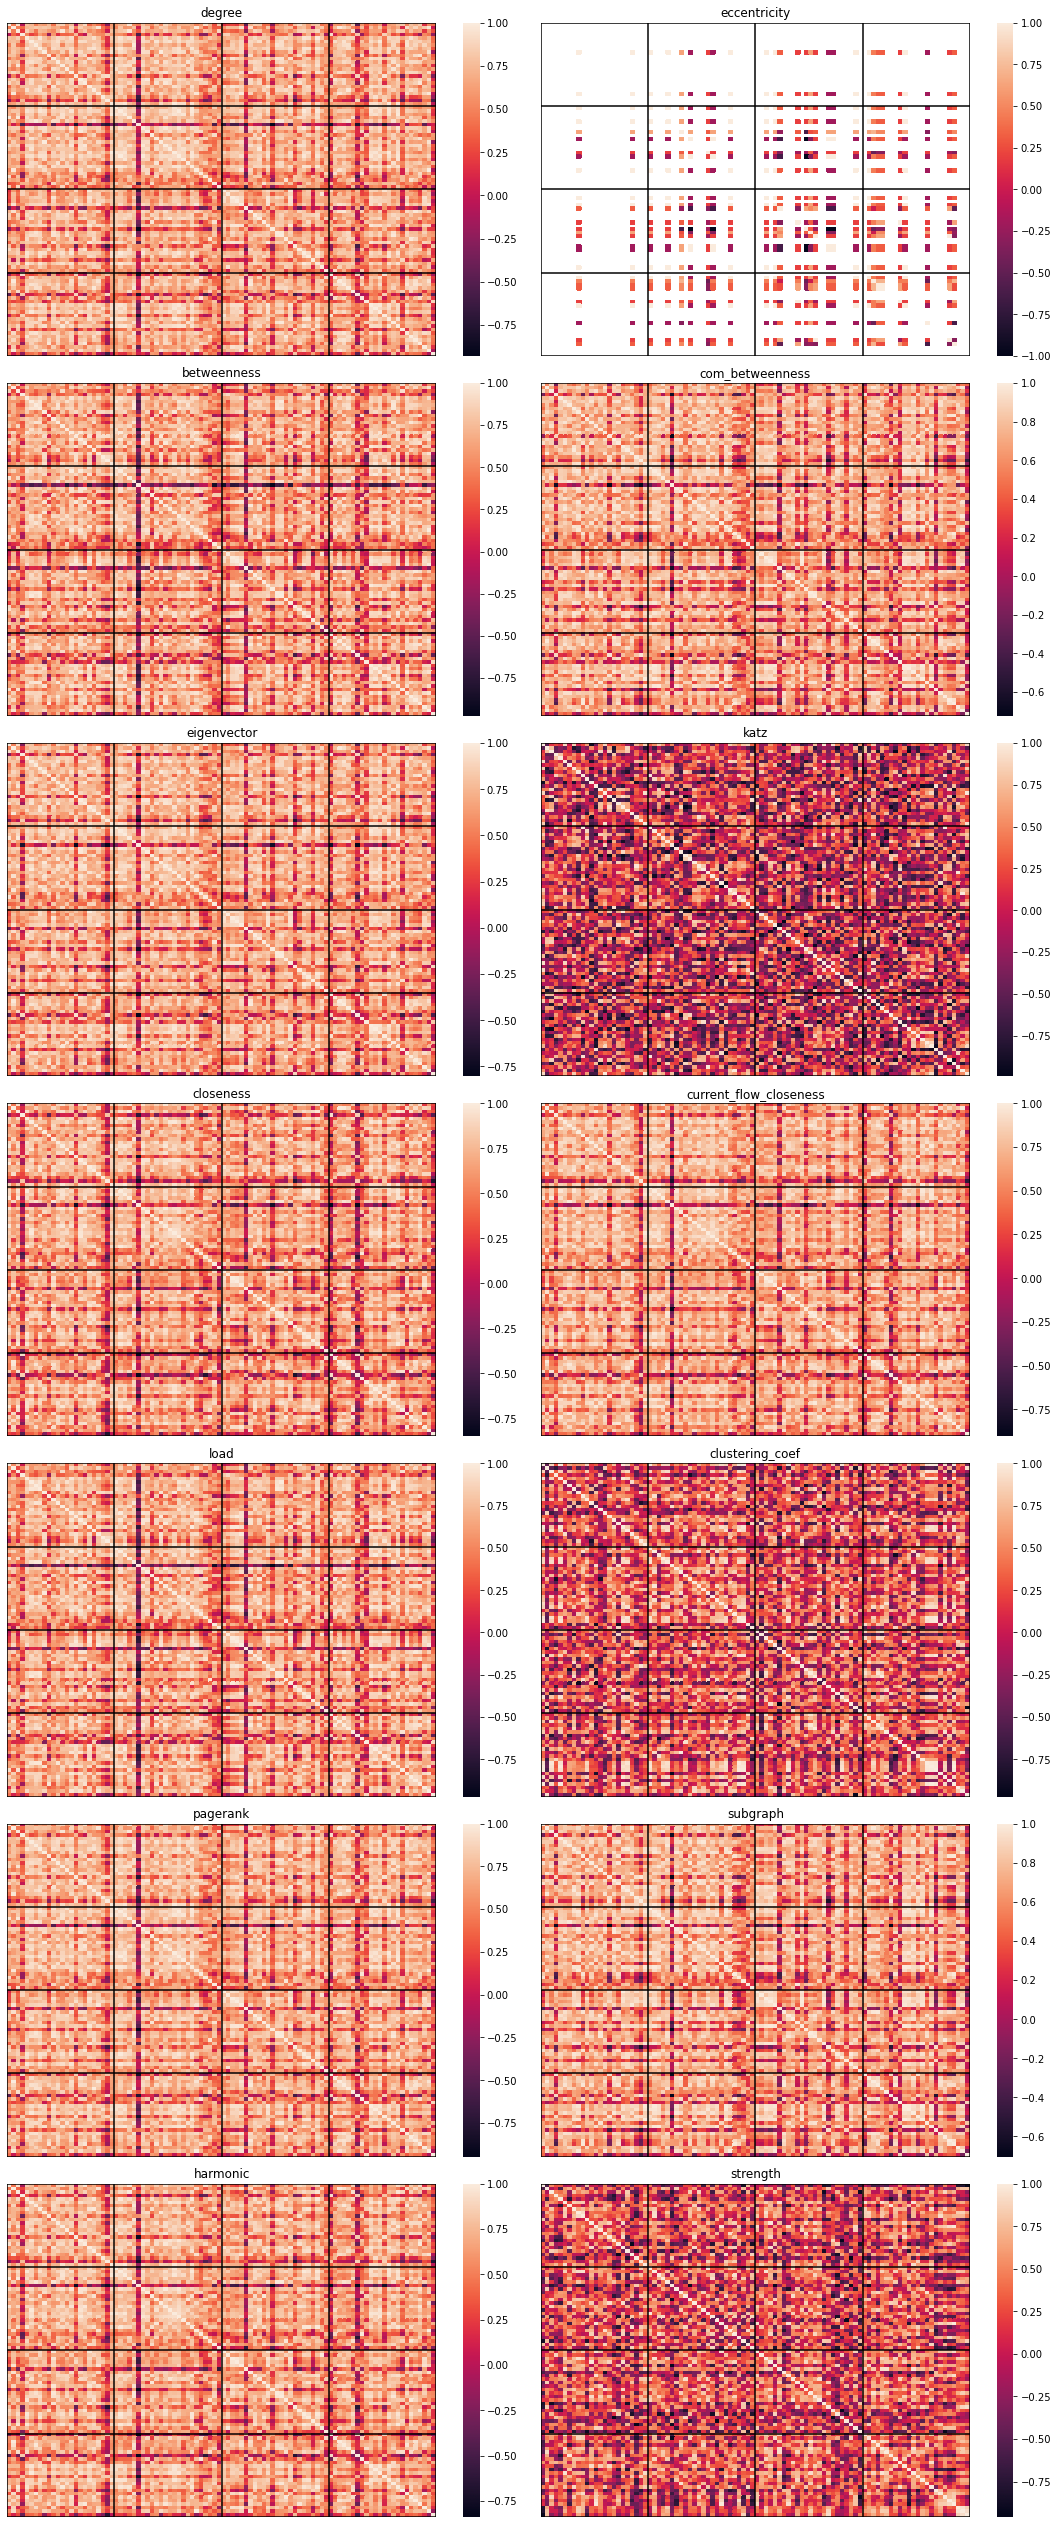

In [34]:
print('sections : ',subjects_groups)
print('size     : ',sep)
ff = plt.figure(figsize=(15,35))
ax = [ff.add_subplot(int((len(mes)+1)/2),2,k+1) for k in range(len(mes))]
dr =[]
for sr in str_loc:
    for i in range(len(mes)):
        ax[i].title.set_text(mes[i])
        dr = sns.heatmap(mtx[mes[i]][sr],xticklabels=False,yticklabels=False,ax=ax[i])
        dr.hlines(sep, *dr.get_xlim())
        dr.vlines(sep, *dr.get_xlim())
plt.tight_layout(pad=.5)
plt.show()

### Standard error and confidence intervals for measures

In [35]:
CR = {}
comb = {}
for sr in str_loc:
    CR[sr] = {}
    comb[sr] ={}
    for i in range(len(sep)-1):
        CR[sr][subjects_groups[i]]={}
        comb[sr][subjects_groups[i]]={}
        for m1 in mes:
            CR[sr][subjects_groups[i]][m1]=[]
            comb[sr][subjects_groups[i]][m1]=[]
            for m2 in mes:
                for s in cols[sep[i]:sep[i+1]]:
                    comb[sr][subjects_groups[i]][m1].append(m2[0:5])
                    CR[sr][subjects_groups[i]][m1].append(np.corrcoef(
                        measures['all'][sr][s][m1].values,
                        measures['all'][sr][s][m2].values)[1,0])
            comb[sr][subjects_groups[i]][m1] = np.array(comb[sr][subjects_groups[i]][m1])
            CR[sr][subjects_groups[i]][m1] = np.array(CR[sr][subjects_groups[i]][m1])
            idx = np.where(1 * np.isnan(CR[sr][subjects_groups[i]][m1])==0)[0]
            comb[sr][subjects_groups[i]][m1] = comb[sr][subjects_groups[i]][m1][idx]
            CR[sr][subjects_groups[i]][m1] = CR[sr][subjects_groups[i]][m1][idx]

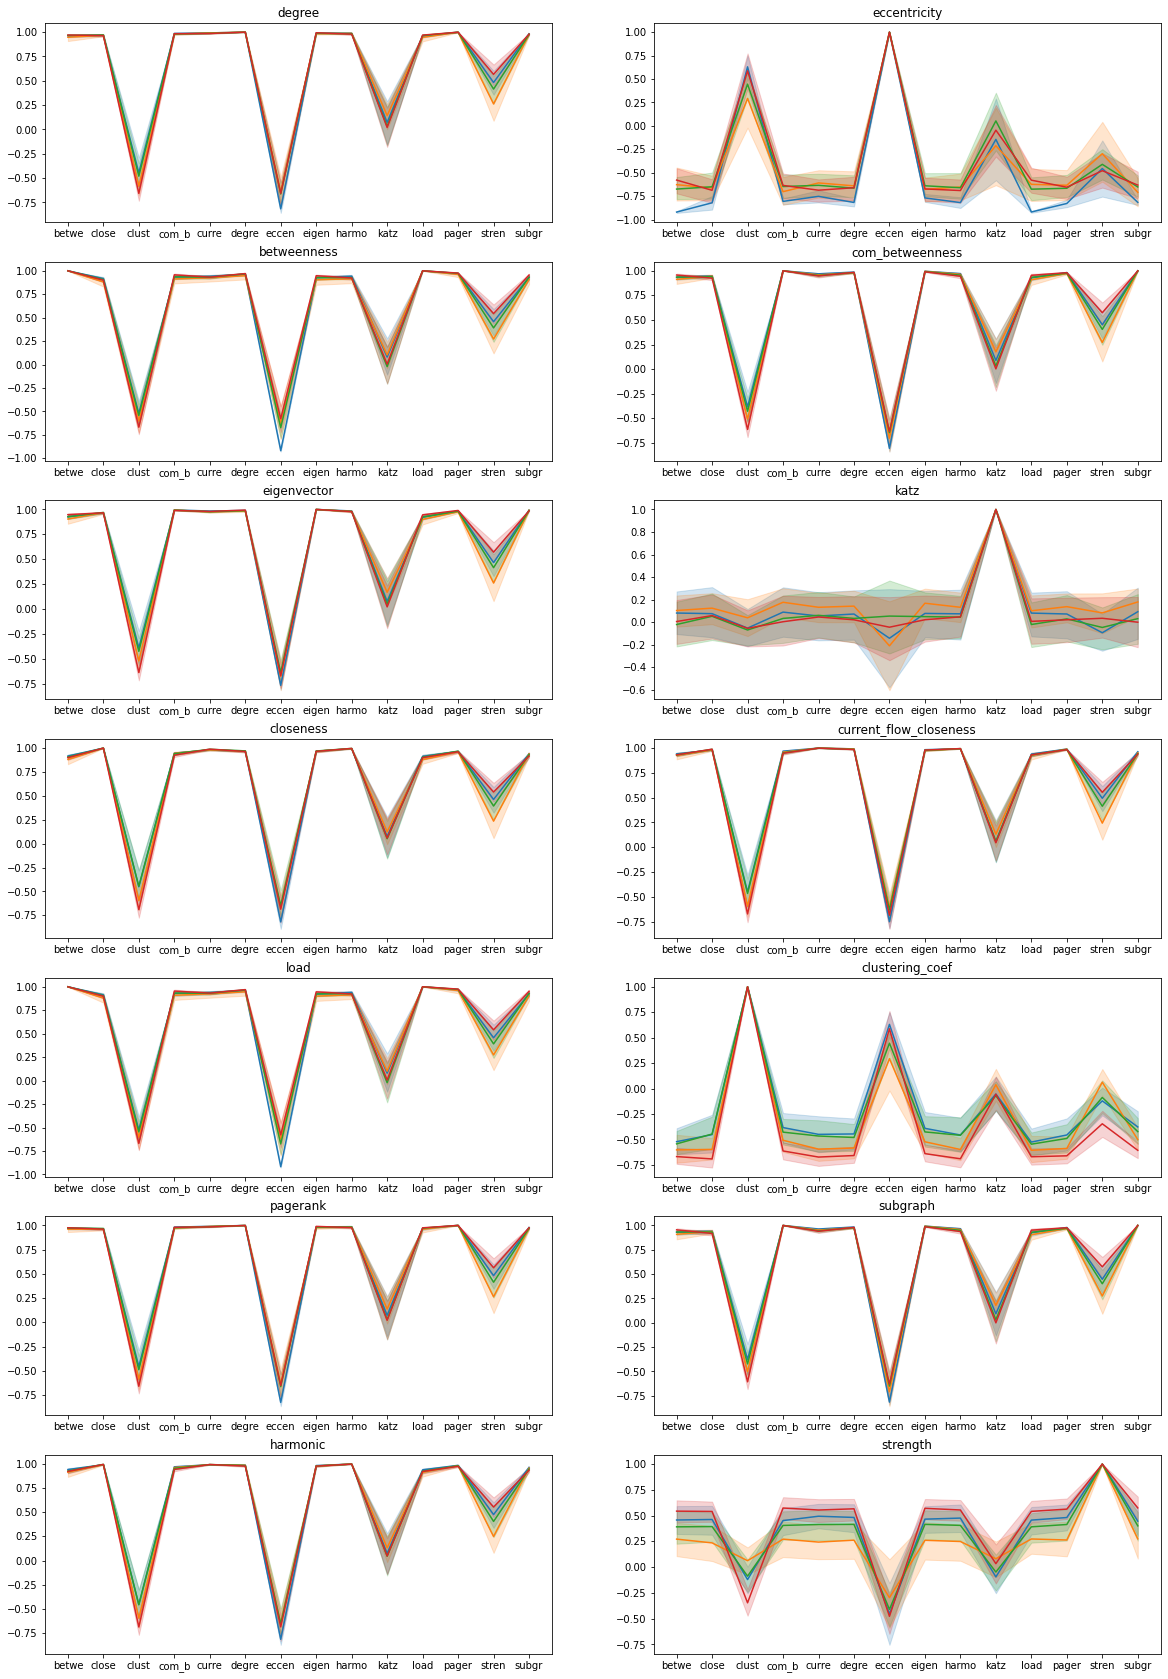

In [36]:
ff = plt.figure(figsize=(20,30))
ax = [ff.add_subplot(int(((len(mes))+1)/2),2,k+1) for k in range(len(mes))]
dr =[]
for i in range(len(mes)):
    for g in subjects_groups:
        dr.append(sns.lineplot(x=comb['loc_36p'][g][mes[i]], y=CR['loc_36p'][g][mes[i]],ax=ax[i]))
    ax[i].title.set_text('%s'%mes[i])

##### Correlation based on the mean of different local centraliry measures for each subject.

In [37]:
sub_rel = gla.sub_rel(measures,sg,strlist,'36p')

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


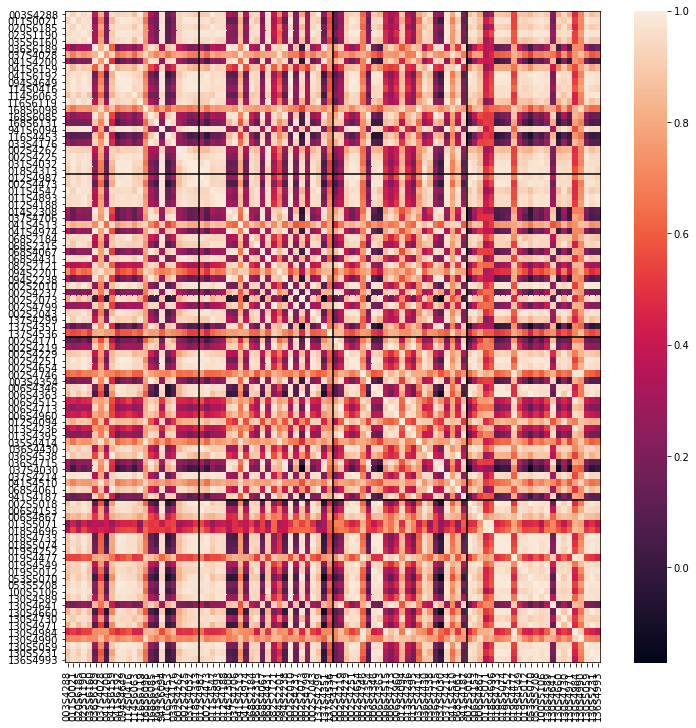

In [38]:
ordered = sub_rel['corr']['loc_36p']['all'][cols]
ordered = ordered.T[cols]
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(ordered,xticklabels=True,yticklabels=True,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [39]:
color = []
n = len(subjects_groups)
for i in range(n):
    color.append('#%06X' % random.randint(0, 0xFFFFFF))

In [40]:
lut = {}
for i in range(n):
    if i != 0:
        for j in range(sep[i-1],sep[i]):
            lut[cols[j]] = color[i]
    if i == 0:
        for j in range(sep[i]):
            lut[cols[j]] = color[i]
cl = pd.DataFrame(lut, index=[1])

['#10A73B', '#78061B', '#BF1A9D', '#4A55A5']
['CN', 'EMCI', 'LMCI', 'AD']


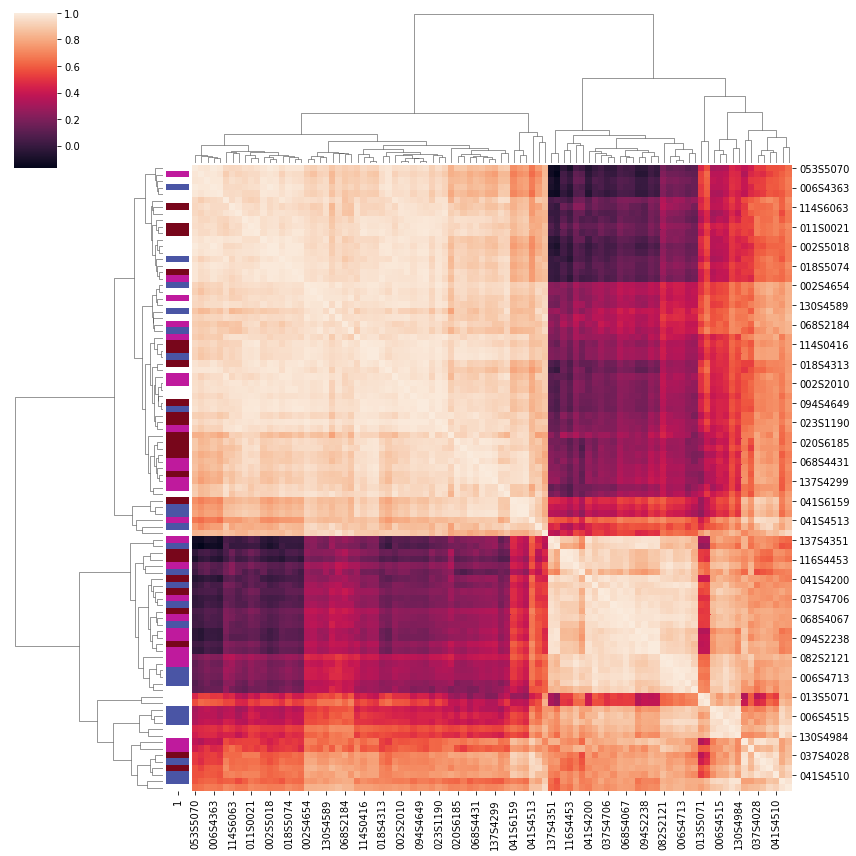

In [41]:
print(color)
print(subjects_groups)
g = sns.clustermap(ordered, row_colors=cl.T,figsize=(12, 12))

#### Correlation based on correlation matrices

In [42]:
subL = []
subLRAW = []
removed = []
if enodes_name!= 'all':
    removed = [i for i in range(360) if i not in enodes]
for s in cols:
    M = gla.read_M(s,ds,ct)
    for i in removed:
        M[i,:]= np.zeros(np.shape(M)[0])
        M = M.T
        M[i,:]= np.zeros(np.shape(M)[0])
        M = M.T
    subLRAW.append(M - np.mean(M))
    M = M[enodes,:][:,enodes]
    subL.append(M - np.mean(M))

In [43]:
rv_results = ho.RVcoeff(subL)

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


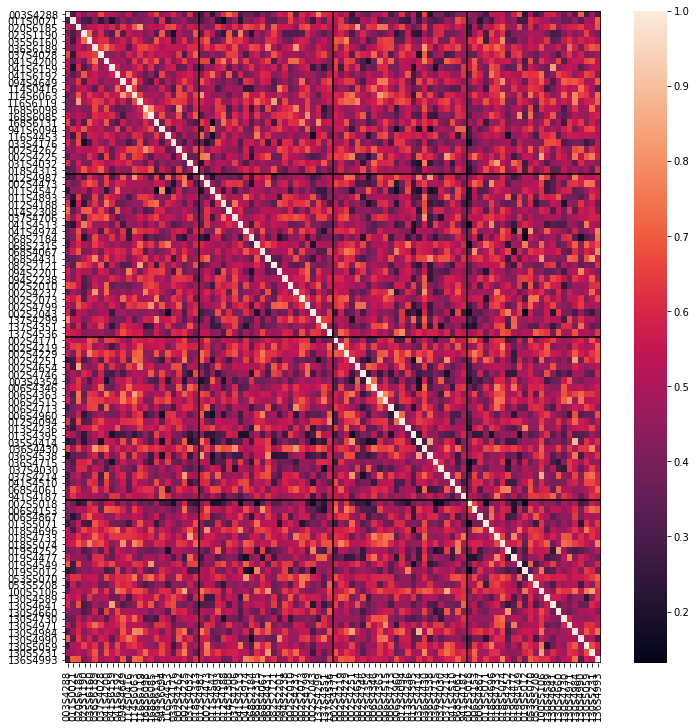

In [44]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(rv_results,xticklabels=cols,yticklabels=cols,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [45]:
subC = 0
for i in range(sep[-1]):
    try:
        subC = np.concatenate((subC,subL[i].reshape((1,np.shape(subL[3])[0]*np.shape(subL[3])[0]))), axis=0)
    except ValueError:
        subC = subL[i].reshape((1,np.shape(subL[3])[0]*np.shape(subL[3])[0]))

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


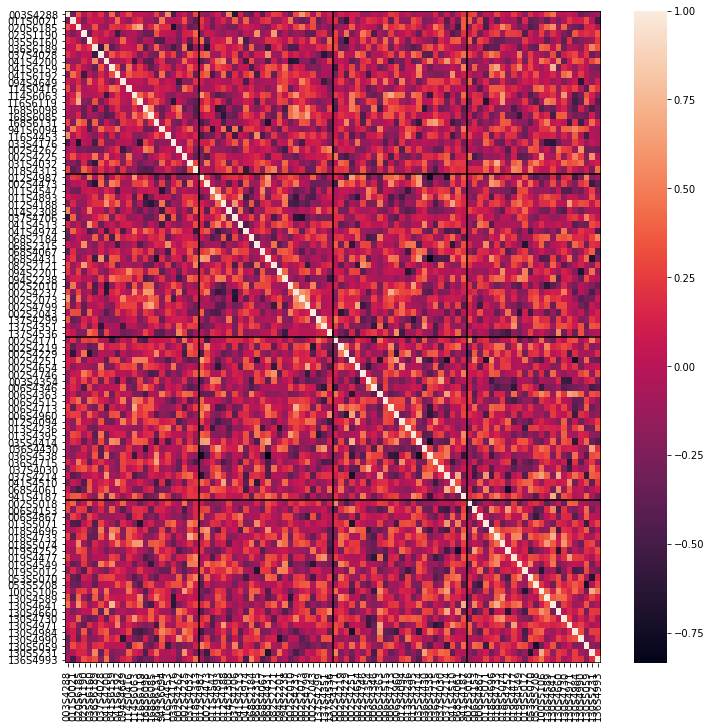

In [46]:
pearsonC = np.corrcoef(subC, y=None, rowvar=True)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(pearsonC,xticklabels=cols,yticklabels=cols,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

mantelC = np.zeros((sep[-1], sep[-1]), float)
for i in range(sep[-1]):
    for j in range(i+1,sep[-1]):
        a = subL[i]
        b = subL[j]
        np.fill_diagonal(a, 0)
        np.fill_diagonal(b, 0)
        a = np.round(a, 9)
        b = np.round(b, 9)
        mantelC[i,j] = mantel(a,b)[0]

mantelC = np.where(mantelC,mantelC,mantelC.T)

fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(mantelC,xticklabels=False,yticklabels=False,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

### Mean Network

#### Construct the mean network of all subjects from different groups:

In [47]:
os.system("mkdir -p %s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/"%(rootdir,tm,ct,ds))
meanM = {}
meanG = {}
for g in range(len(subjects_groups)):
    con  = np.dstack(subLRAW[sep[g]:sep[g+1]])
    meanM[subjects_groups[g]] = np.mean(con, axis=2)
    meanG[subjects_groups[g]] = nx.from_numpy_matrix(meanM[subjects_groups[g]])
    nx.write_gexf(meanG[subjects_groups[g]],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'corr',ds,ct,tm))                    
    np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'corr',ds,ct,tm), meanM[subjects_groups[g]] )

con = np.dstack(subLRAW[0:sep[-1]])
meanM['all'] = np.mean(con, axis=2)
meanG['all'] = nx.from_numpy_matrix(meanM['all'])
nx.write_gexf(meanG['all'],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
              %(rootdir,tm,ct,ds,'all','corr',ds,ct,tm))                    
np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
        %(rootdir,tm,ct,ds,'all','corr',ds,ct,tm), meanM['all'])

#### Visualize the mean networks:

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


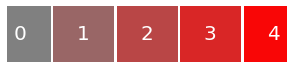

Top 0.5% edges Of Mean Network of correlation matrices Between CN Subjects


/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


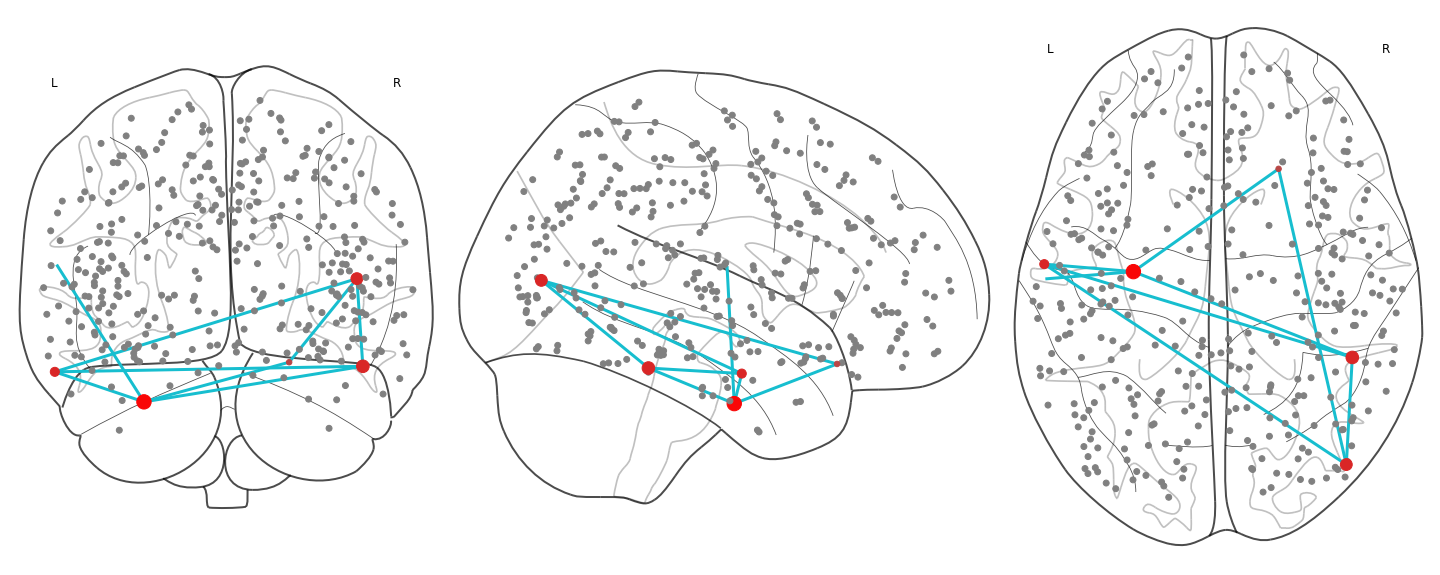

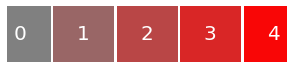

Top 0.5% edges Of Mean Network of correlation matrices Between EMCI Subjects


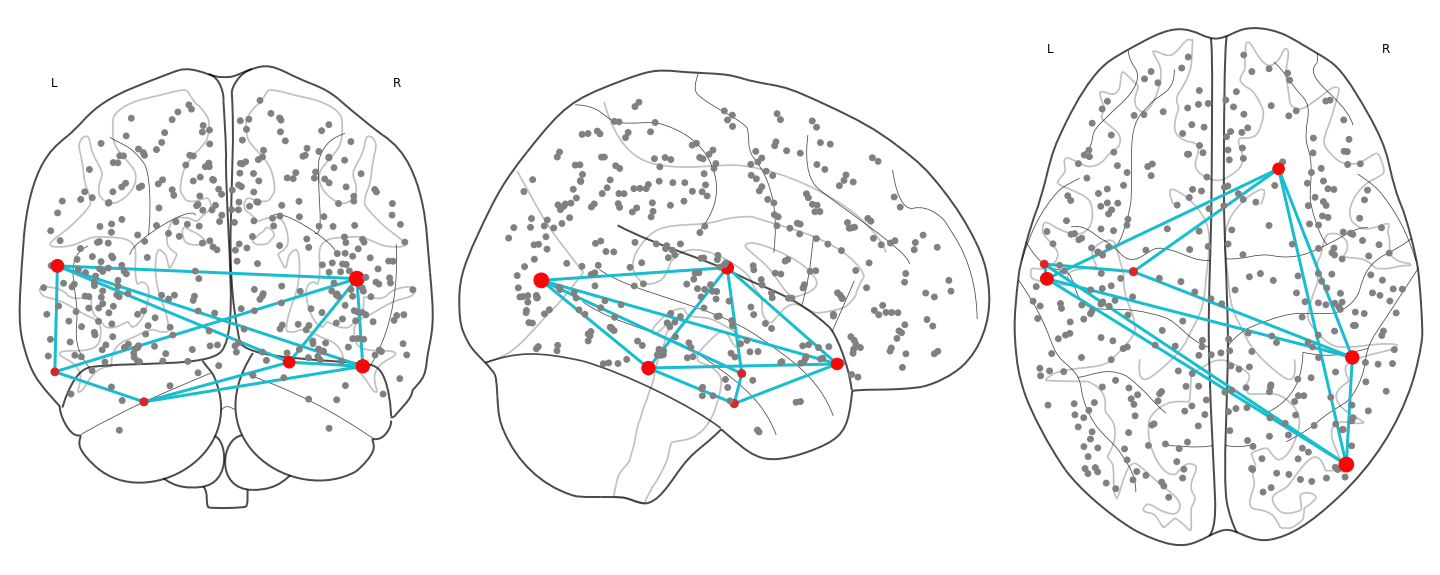

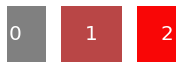

Top 0.5% edges Of Mean Network of correlation matrices Between LMCI Subjects


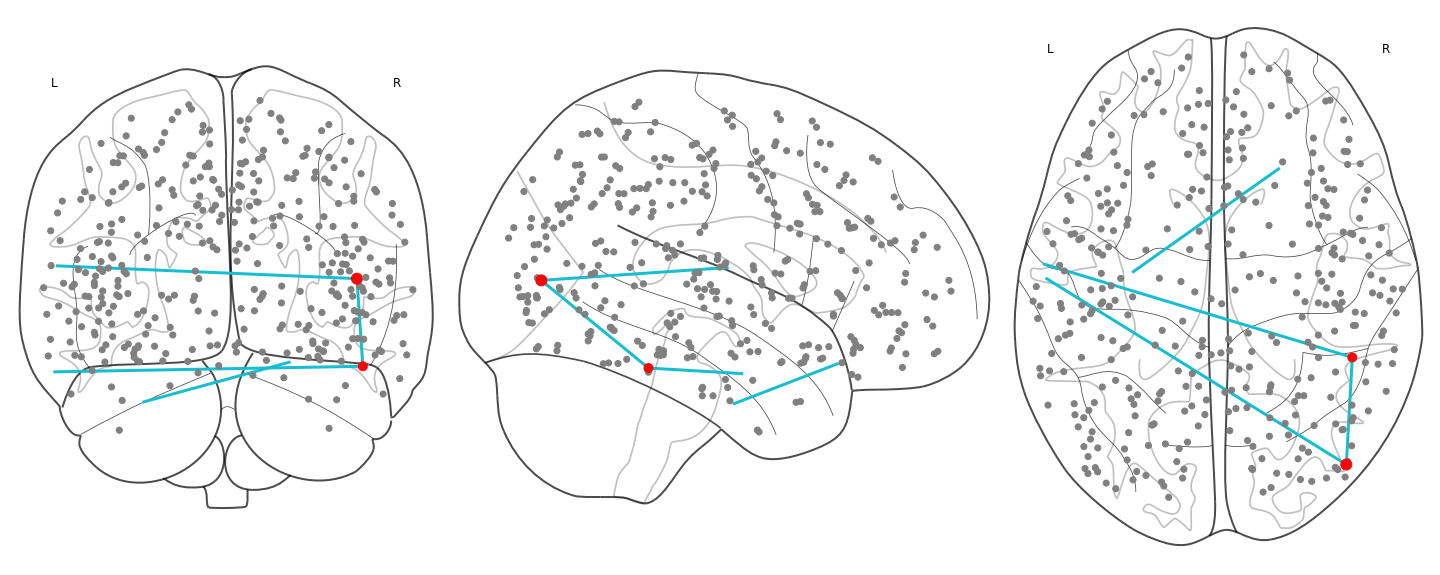

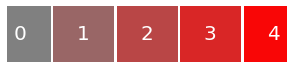

Top 0.5% edges Of Mean Network of correlation matrices Between AD Subjects


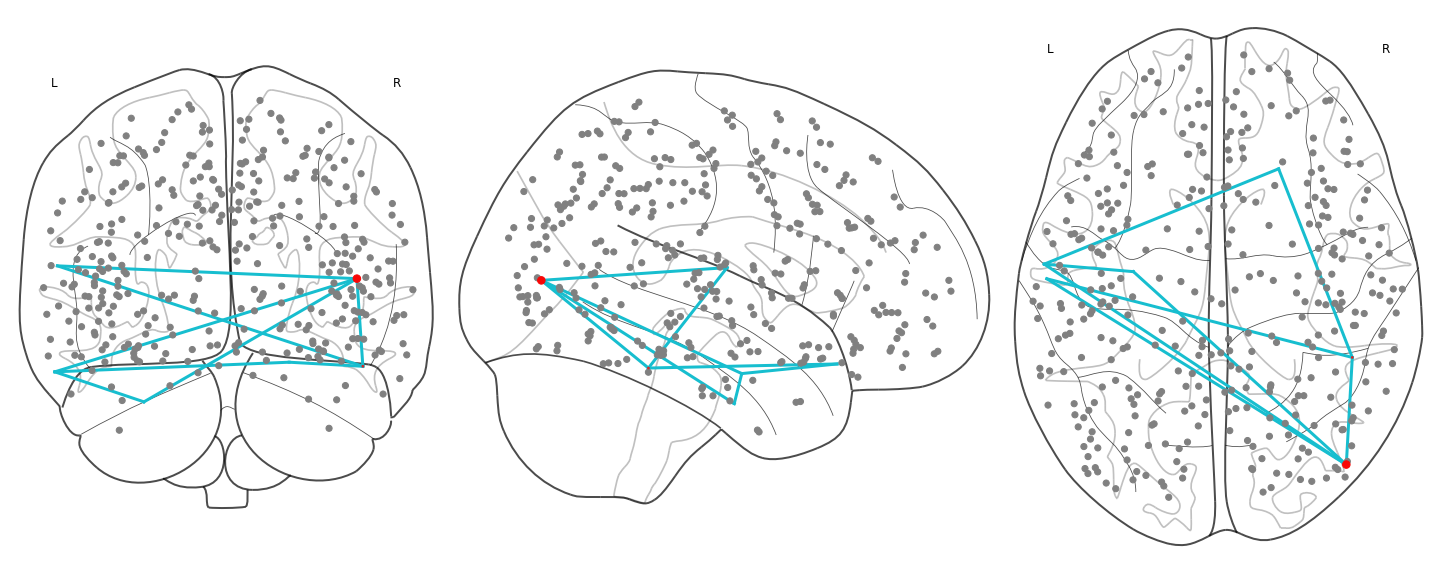

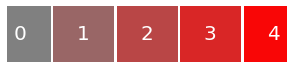

Top 0.5% edges Of Mean Network of correlation matrices Between all Subjects


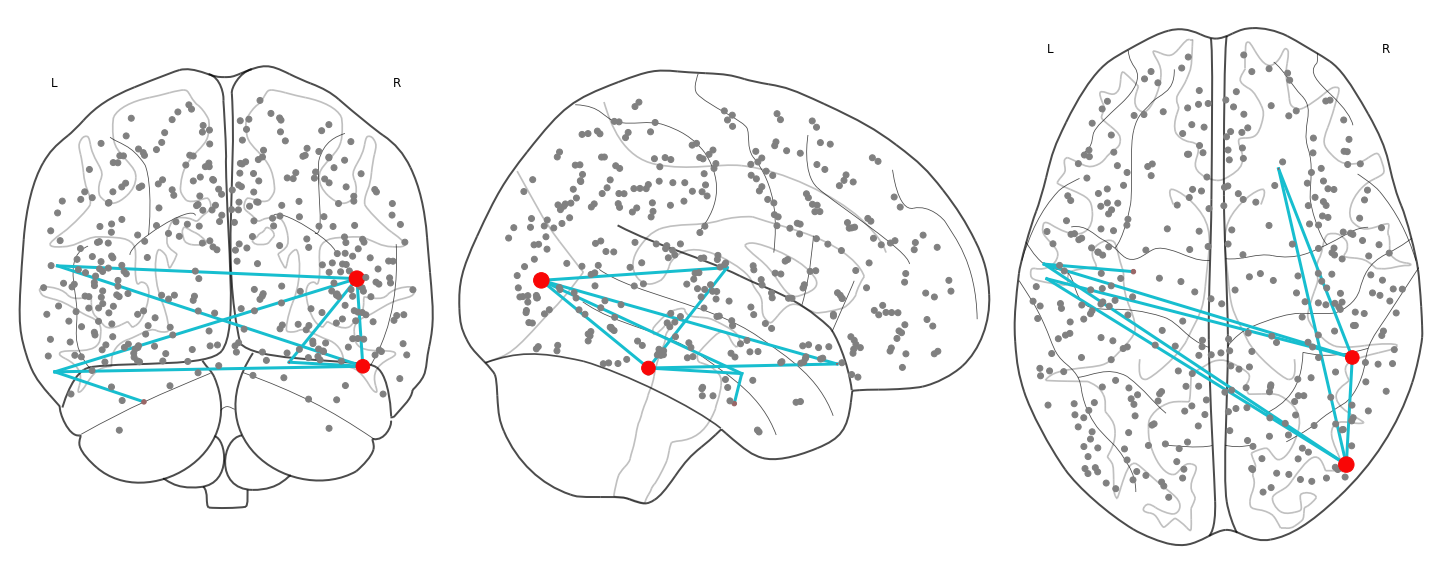

In [48]:
dirc = rootdir + "/figs/mean_network/corr"
for g in sg:
    title = "Top 0.5%% edges Of Mean Network of correlation matrices Between %s Subjects"%g
    viz.brain_viz_from_path(cm = meanM[g],title=title,density=.005,method='2d')

#### Correlation between the mean networks and the subjects

In [49]:
mean_sub = np.zeros((len(cols),len(subjects_groups)))
for j in range(len(subjects_groups)):
    mv = meanM[subjects_groups[j]].reshape((1,np.shape(subLRAW[3])[0]*np.shape(subLRAW[3])[0]))
    for i in range(len(cols)):
        s = subLRAW[i].reshape((1,np.shape(subLRAW[3])[0]*np.shape(subLRAW[3])[0]))
        mean_sub[i,j] = np.corrcoef(mv,s)[0,1]

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


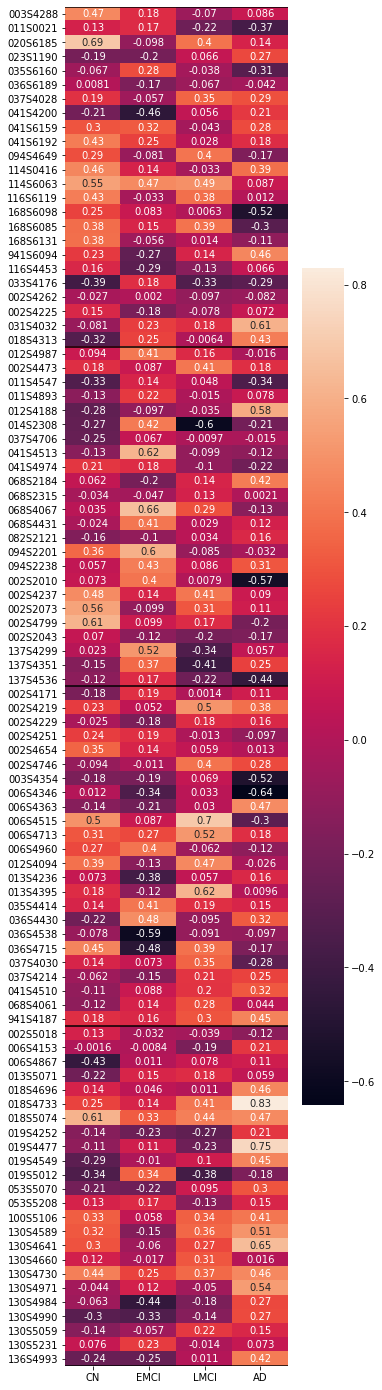

In [50]:
fig, ax = plt.subplots(figsize=(5,25))         # Sample figsize in inches
ax = sns.heatmap(mean_sub,
            xticklabels=subjects_groups,
            yticklabels=cols,
            annot=True, ax = ax)
ax.hlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

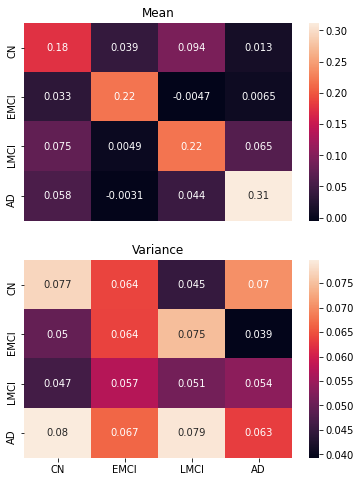

In [51]:
m_mean_sub = np.zeros((len(subjects_groups),len(subjects_groups)))
v_mean_sub = np.zeros((len(subjects_groups),len(subjects_groups)))
for i in range(len(subjects_groups)):
    for j in range(len(subjects_groups)):
        m_mean_sub[i,j]= np.mean(mean_sub[sep[j]:sep[j+1],i])
        v_mean_sub[i,j]= np.var(mean_sub[sep[j]:sep[j+1],i])

plt.figure(figsize=(6,8))

plt.subplot(211)
sns.heatmap(m_mean_sub,yticklabels=subjects_groups,
            annot=True,xticklabels=False)
plt.title('Mean')
plt.subplot(212)

sns.heatmap(v_mean_sub,yticklabels=subjects_groups,
            annot=True,xticklabels=subjects_groups)
plt.title('Variance')
plt.show()

### Standard error and confidence intervals for selected nodes

In [52]:
nodeCR = {}
comb = {}
for sr in str_loc:
    nodeCR[sr] = {}
    comb[sr] ={}
    for i in range(len(sep)-1):
        nodeCR[sr][subjects_groups[i]]=[]
        comb[sr][subjects_groups[i]]=[]
        for nd in snd:
            for s in list(range(sep[i],sep[i+1])):
                comb[sr][subjects_groups[i]].append(str(nd))
                nodeCR[sr][subjects_groups[i]].append(subLRAW[s][nd[0],nd[1]])
    comb[sr][subjects_groups[i]] = np.array(comb[sr][subjects_groups[i]])
    nodeCR[sr][subjects_groups[i]] = np.array(nodeCR[sr][subjects_groups[i]])
    idx = np.where(1 * np.isnan(nodeCR[sr][subjects_groups[i]])==0)[0]
    comb[sr][subjects_groups[i]] = comb[sr][subjects_groups[i]][idx]
    nodeCR[sr][subjects_groups[i]] = nodeCR[sr][subjects_groups[i]][idx]

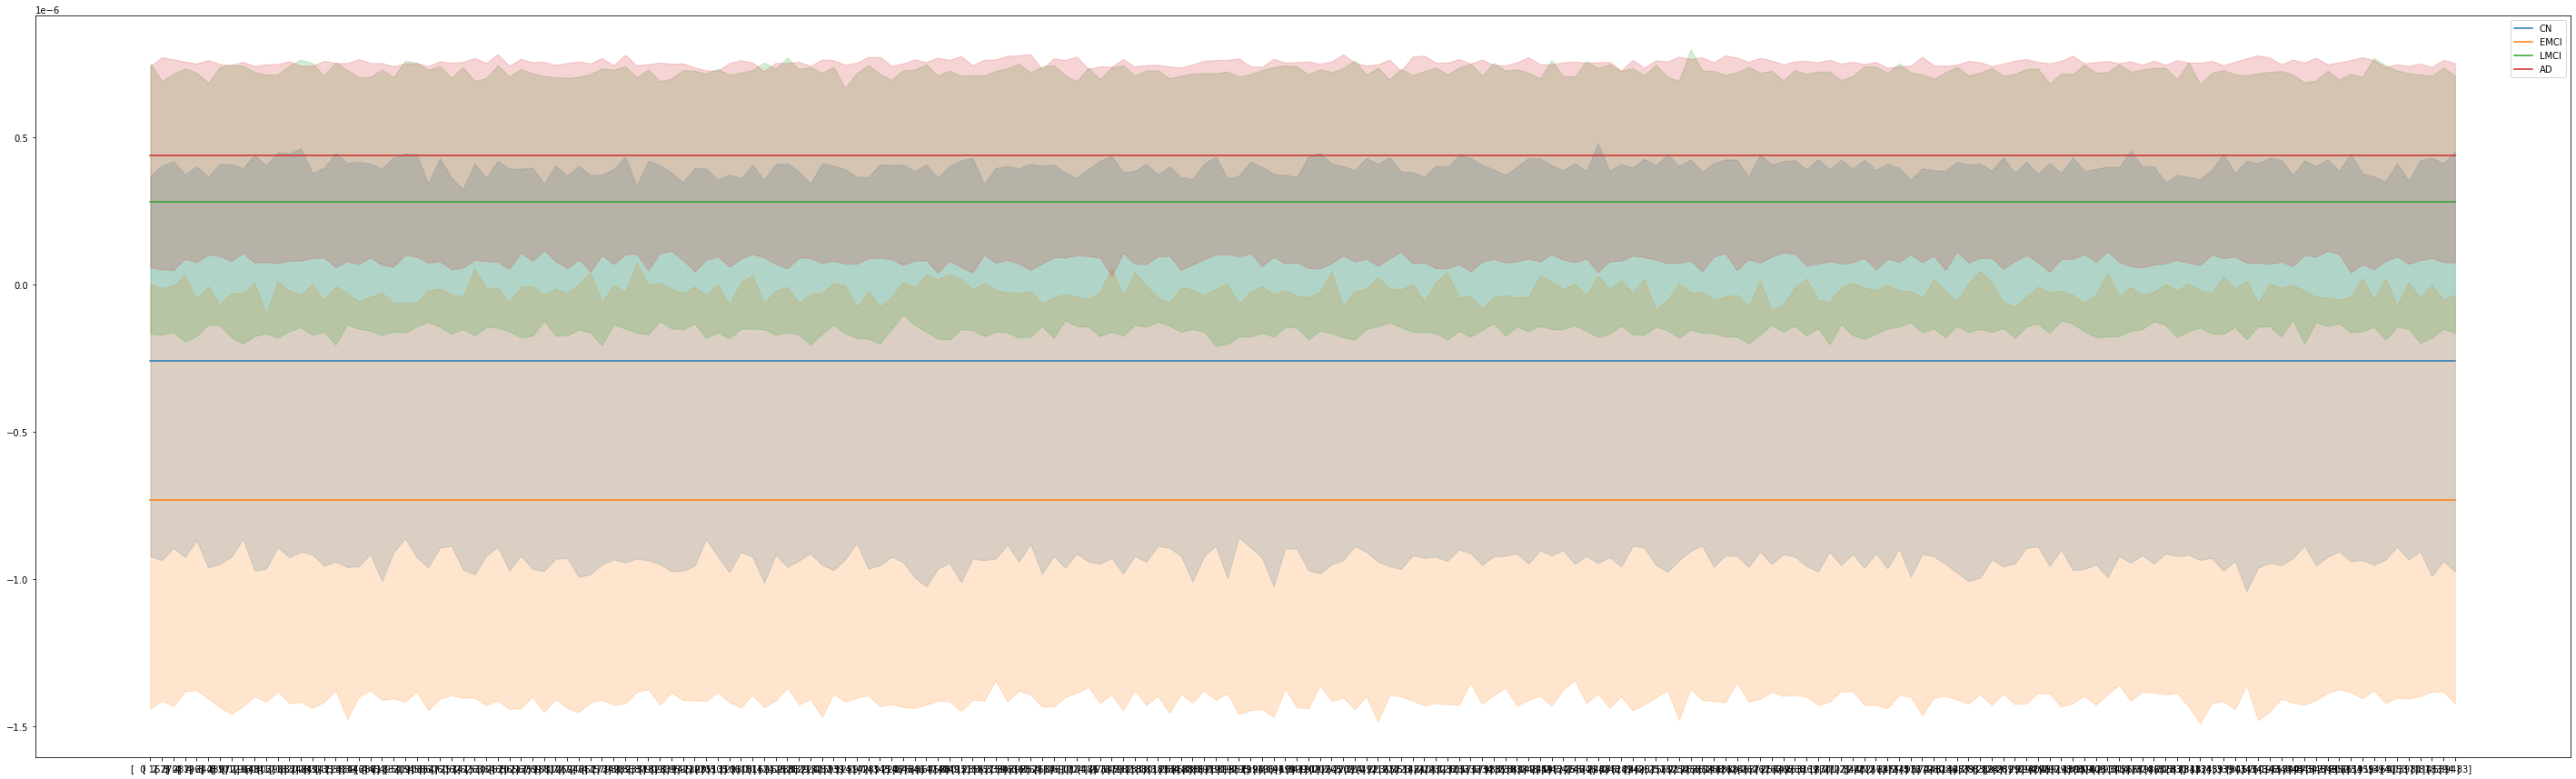

In [53]:
plt.figure(figsize=(50,15))
dr =[]
for g in subjects_groups:
    dr.append(sns.lineplot(x=comb['loc_36p'][g], y=nodeCR['loc_36p'][g]))
plt.legend(subjects_groups)

#### Correlation between the mean networks 

In [54]:
M = 0
for g in subjects_groups:
    try:
        M = np.concatenate((M,meanM[g].reshape((np.shape(subLRAW[3])[0]*np.shape(subLRAW[3])[0],1))), axis=1)
    except ValueError:
        M = meanM[g].reshape((np.shape(subLRAW[3])[0]*np.shape(subLRAW[3])[0],1))
        
mean_corr = np.corrcoef(M.T)

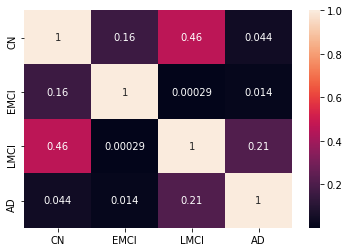

In [55]:
sns.heatmap(mean_corr,
            yticklabels=subjects_groups,
            xticklabels=subjects_groups,
            annot=True)

#### Correlation based on Adjacency matrices

In [56]:
subL_adj = []
subLRAW_adj = []
removed = []
if enodes_name!= 'all':
    removed = [i for i in range(360) if i not in enodes]
for s in cols:
    M = gla.read_adj_M(s,ds,ct,tm,negative=negative_corr)
    for i in removed:
        M[i,:]= np.zeros(np.shape(M)[0])
        M = M.T
        M[i,:]= np.zeros(np.shape(M)[0])
        M = M.T
    subLRAW_adj.append(M - np.mean(M))
    M = M[enodes,:][:,enodes]
    subL_adj.append(M - np.mean(M))

In [57]:
rv_results_adj = ho.RVcoeff(subL_adj)

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/hoggorm/mat_corr_coeff.py:89: RuntimeWarning: invalid value encountered in double_scalars
  Rv = nom / numpy.sqrt(numpy.dot(denom1, denom2))


sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


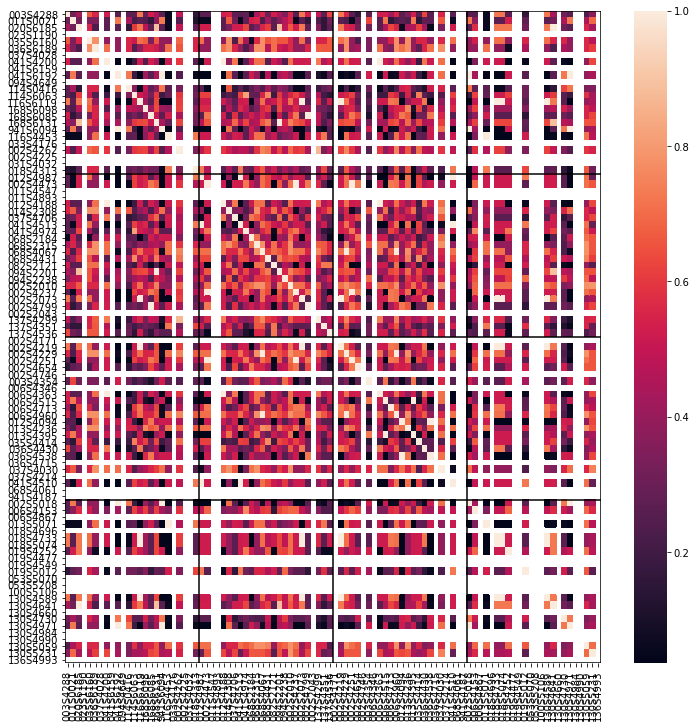

In [58]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(rv_results_adj,xticklabels=cols,yticklabels=cols,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [59]:
subC_adj = 0
for i in range(sep[-1]):
    try:
        subC_adj = np.concatenate((subC_adj,subL_adj[i].reshape((1,np.shape(subL_adj[3])[0]*np.shape(subL_adj[3])[0]))), axis=0)
    except ValueError:
        subC_adj = subL_adj[i].reshape((1,np.shape(subL_adj[3])[0]*np.shape(subL_adj[3])[0]))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


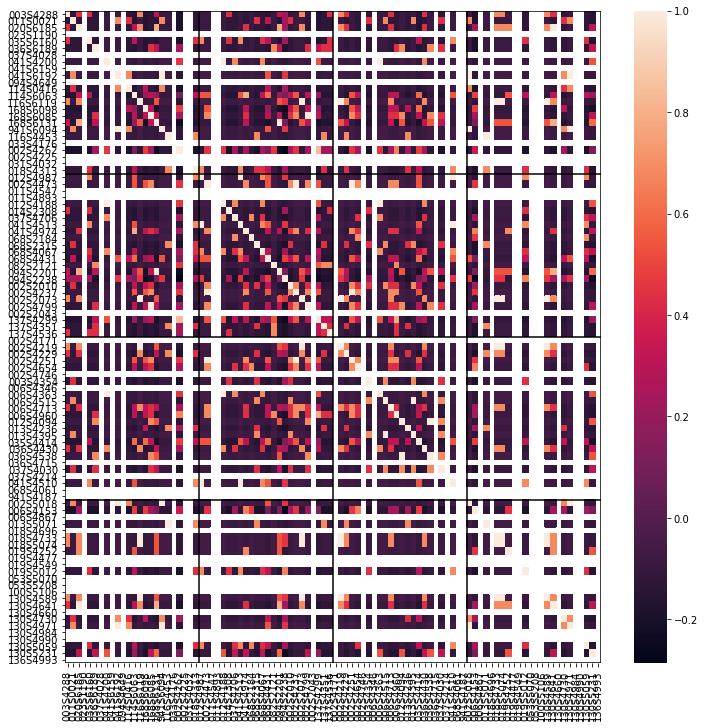

In [60]:
pearsonC = np.corrcoef(subC_adj, y=None, rowvar=True)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(pearsonC,xticklabels=cols,yticklabels=cols,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

mantelC = np.zeros((sep[-1], sep[-1]), float)
for i in range(sep[-1]):
    for j in range(i+1,sep[-1]):
        a = subL[i]
        b = subL[j]
        np.fill_diagonal(a, 0)
        np.fill_diagonal(b, 0)
        a = np.round(a, 9)
        b = np.round(b, 9)
        mantelC[i,j] = mantel(a,b)[0]

mantelC = np.where(mantelC,mantelC,mantelC.T)

fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(mantelC,xticklabels=False,yticklabels=False,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

np.save("%s/data/08_group_level/mantelC"%(rootdir), mantelC)

### Mean Network

#### Construct the mean network of adjacency matrices of all subjects from different groups:

In [61]:
meanM = {}
meanG = {}
for g in range(len(subjects_groups)):
    con  = np.dstack(subLRAW[sep[g]:sep[g+1]+1])
    meanM[subjects_groups[g]] = np.mean(con, axis=2)
    meanG[subjects_groups[g]] = nx.from_numpy_matrix(meanM[subjects_groups[g]])
    nx.write_gexf(meanG[subjects_groups[g]],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'corr',ds,ct,tm))                    
    np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'corr',ds,ct,tm), meanM[subjects_groups[g]])

con = np.dstack(subLRAW[0:sep[-1]])
meanM['all'] = np.mean(con, axis=2)
meanG['all'] = nx.from_numpy_matrix(meanM['all'])
nx.write_gexf(meanG['all'],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
              %(rootdir,tm,ct,ds,'all','corr',ds,ct,tm))                    
np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
        %(rootdir,tm,ct,ds,'all','corr',ds,ct,tm), meanM['all'])

In [62]:
meanM_adj = {}
meanG_adj = {}
for g in range(len(subjects_groups)):
    con  = np.dstack(subLRAW_adj[sep[g]:sep[g+1]])
    meanM_adj[subjects_groups[g]] = np.mean(con, axis=2)
    meanG_adj[subjects_groups[g]] = nx.from_numpy_matrix(meanM_adj[subjects_groups[g]])
    nx.write_gexf(meanG_adj[subjects_groups[g]],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'adj',ds,ct,tm))                   
    np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
                  %(rootdir,tm,ct,ds,subjects_groups[g],'adj',ds,ct,tm), meanM_adj[subjects_groups[g]])

con = np.dstack(subLRAW_adj[0:sep[-1]])
meanM_adj['all'] = np.mean(con, axis=2)
meanG_adj['all'] = nx.from_numpy_matrix(meanM_adj['all'])
nx.write_gexf(meanG_adj['all'],"%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s.gexf"
              %(rootdir,tm,ct,ds,'all','adj',ds,ct,tm))                    
np.save("%s/data/08_group_level/mean_network/tm-%s/corr-%s/ds-%s/%s_%s_ds-%s_corr-%s_tm-%s"
        %(rootdir,tm,ct,ds,'all','adj',ds,ct,tm), meanM_adj['all'])

#### Visualize the mean networks:

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


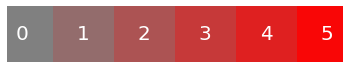

Top 0.5% edges Of Mean Network of adjacency matrices Between CN Subjects


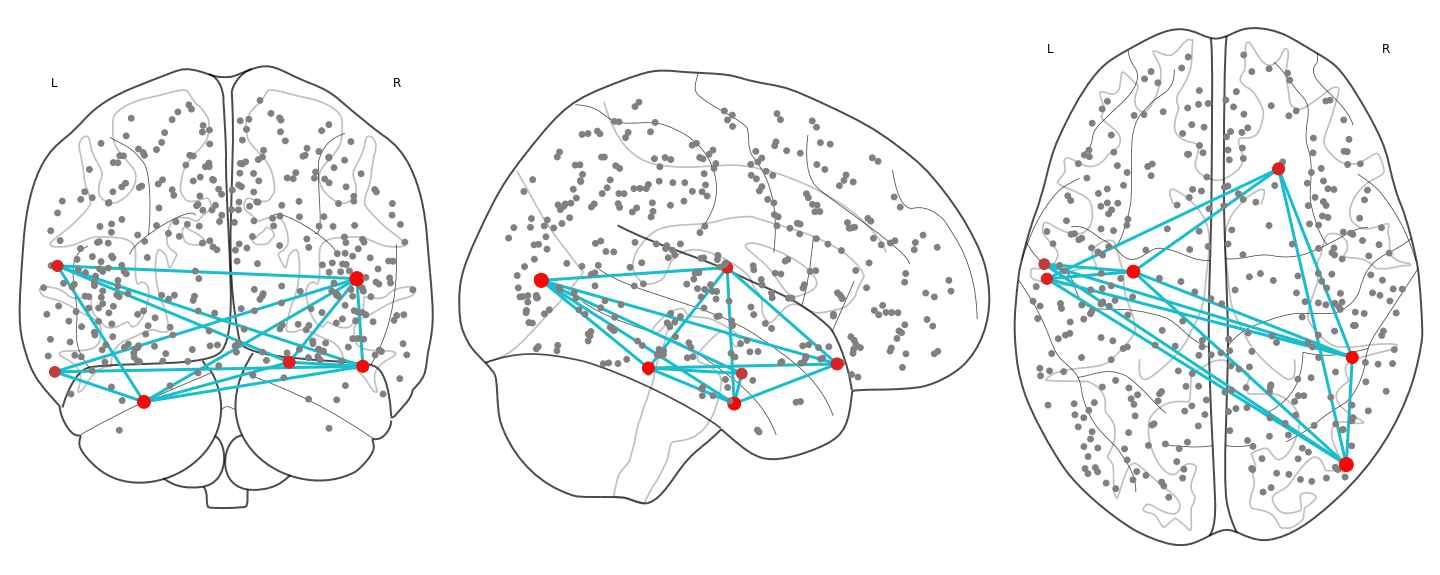

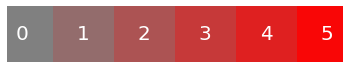

Top 0.5% edges Of Mean Network of adjacency matrices Between EMCI Subjects


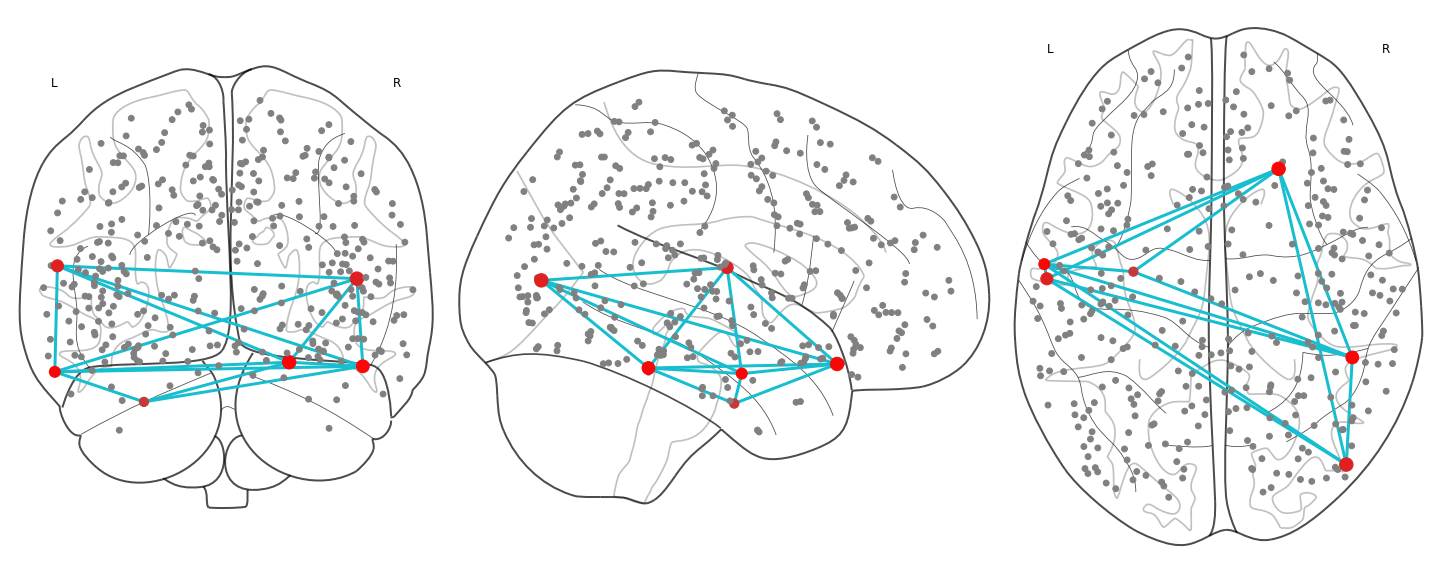

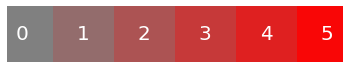

Top 0.5% edges Of Mean Network of adjacency matrices Between LMCI Subjects


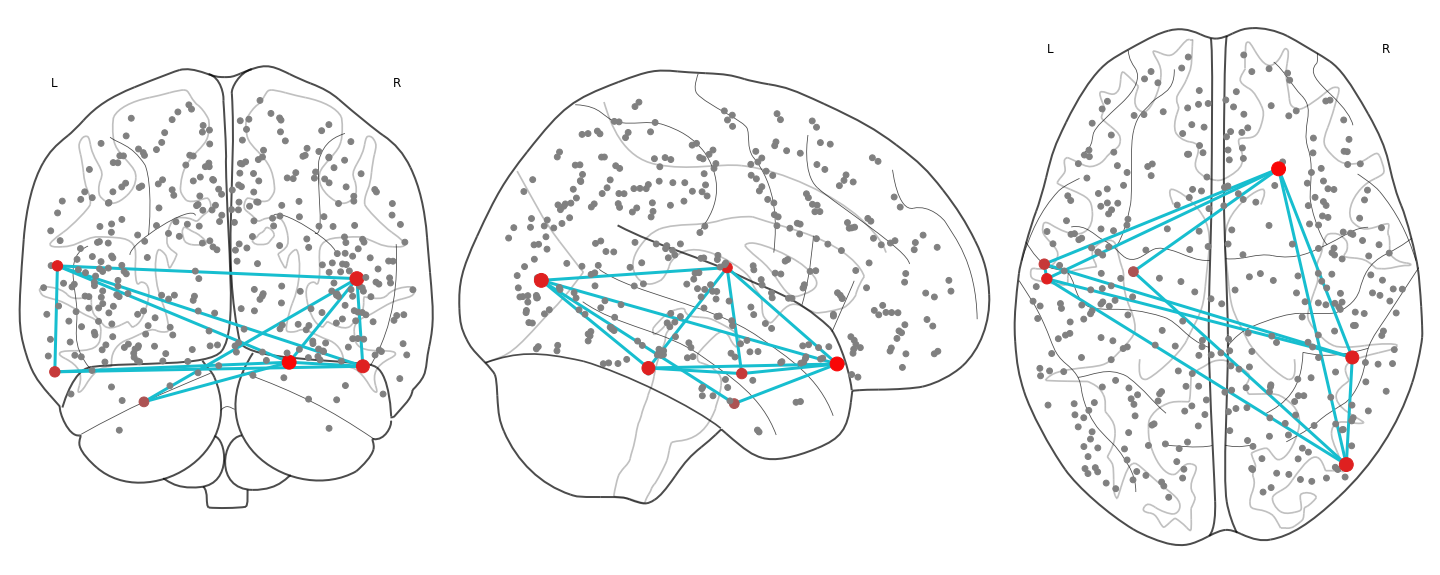

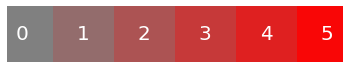

Top 0.5% edges Of Mean Network of adjacency matrices Between AD Subjects


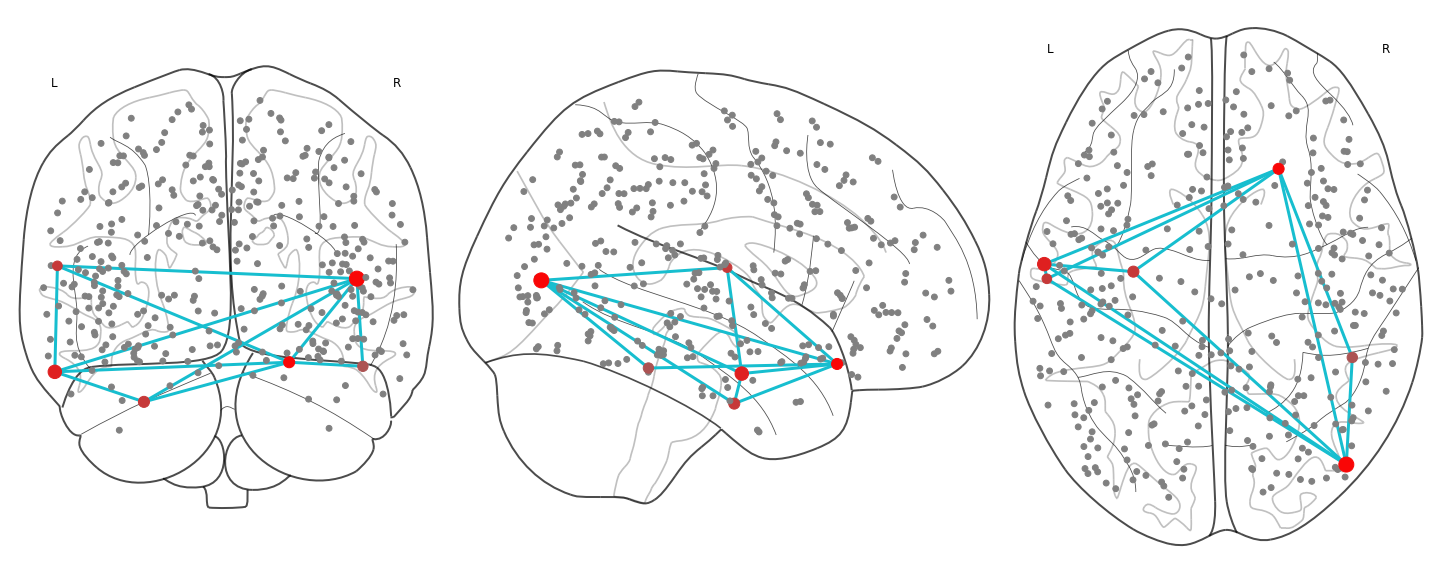

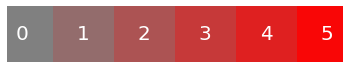

Top 0.5% edges Of Mean Network of adjacency matrices Between all Subjects


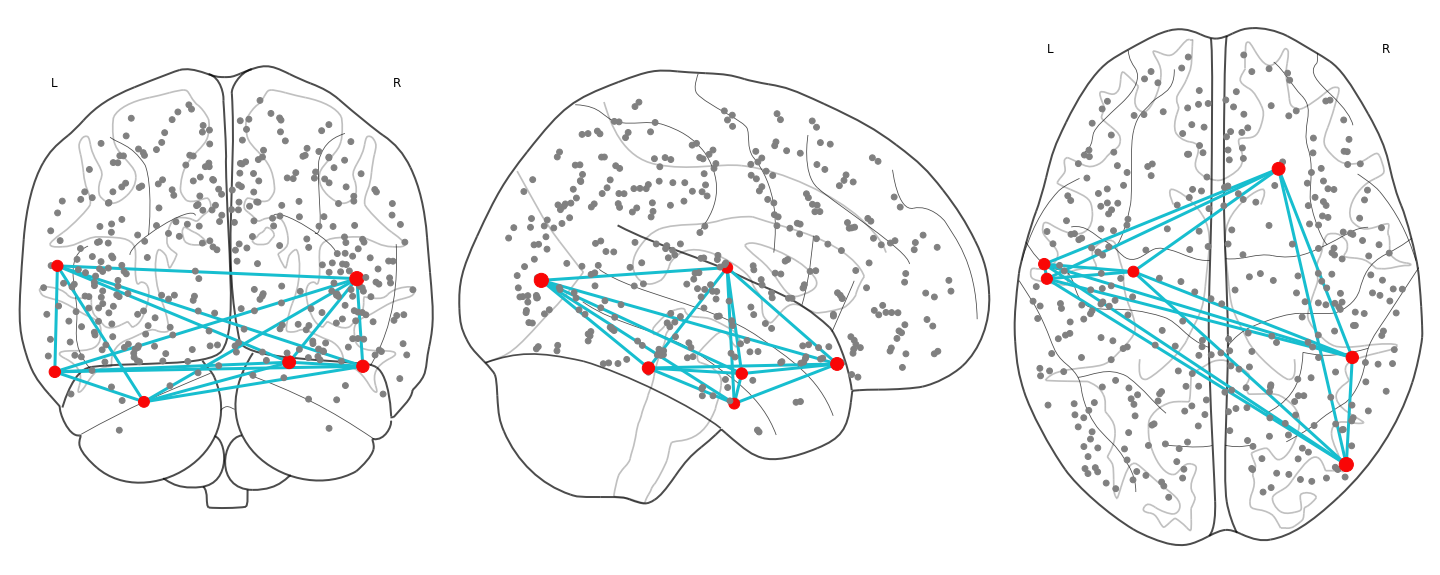

In [63]:
dirc = rootdir + "/figs/mean_network/adj"
for g in sg:
    title = "Top 0.5%% edges Of Mean Network of adjacency matrices Between %s Subjects"%g
    viz.brain_viz_from_path(cm = meanM_adj[g],title=title,density=.005,method='2d')

#### Correlation between the mean networks and the subjects

In [64]:
mean_sub_adj = np.zeros((len(cols),len(subjects_groups)))
for j in range(len(subjects_groups)):
    mv = meanM_adj[subjects_groups[j]].reshape((1,np.shape(subLRAW_adj[3])[0]*np.shape(subLRAW_adj[3])[0]))
    for i in range(len(cols)):
        s = subLRAW_adj[i].reshape((1,np.shape(subLRAW_adj[3])[0]*np.shape(subLRAW_adj[3])[0]))
        mean_sub_adj[i,j] = np.corrcoef(mv,s)[0,1]

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 48, 72, 96]


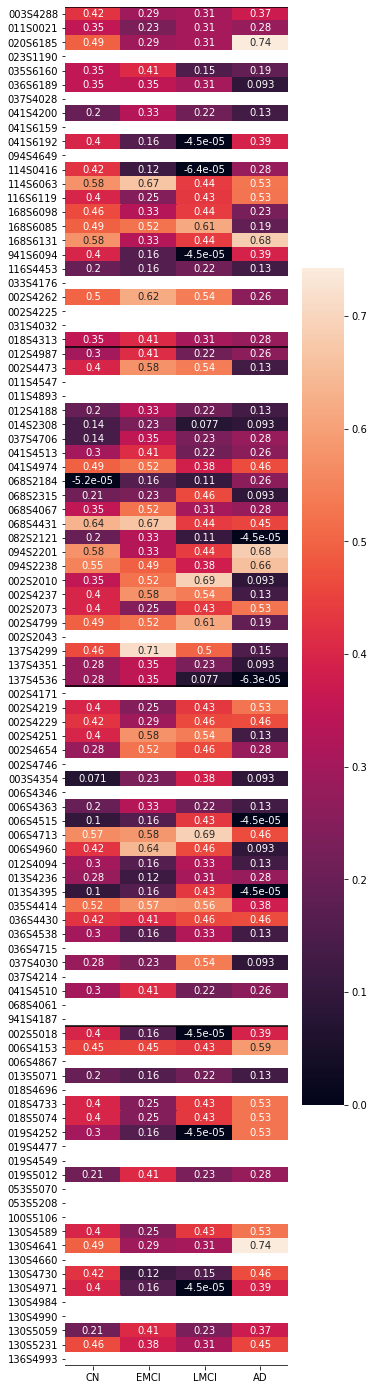

In [65]:
fig, ax = plt.subplots(figsize=(5,25))         # Sample figsize in inches
ax = sns.heatmap(mean_sub_adj,
            xticklabels=subjects_groups,
            yticklabels=cols,
            annot=True, ax = ax)
ax.hlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

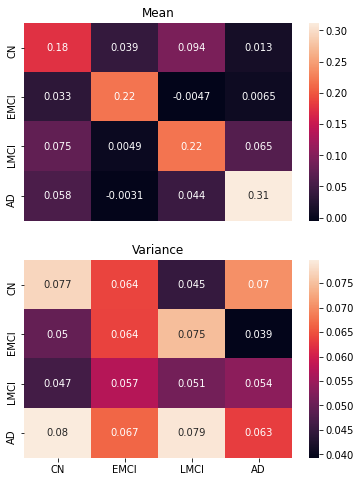

In [66]:
m_mean_sub = np.zeros((len(subjects_groups),len(subjects_groups)))
v_mean_sub = np.zeros((len(subjects_groups),len(subjects_groups)))
for i in range(len(subjects_groups)):
    for j in range(len(subjects_groups)):
        m_mean_sub[i,j]= np.mean(mean_sub[sep[j]:sep[j+1],i])
        v_mean_sub[i,j]= np.var(mean_sub[sep[j]:sep[j+1],i])

plt.figure(figsize=(6,8))

plt.subplot(211)
sns.heatmap(m_mean_sub,yticklabels=subjects_groups,
            annot=True,xticklabels=False)
plt.title('Mean')
plt.subplot(212)

sns.heatmap(v_mean_sub,yticklabels=subjects_groups,
            annot=True,xticklabels=subjects_groups)
plt.title('Variance')
plt.show()

#### Correlation between the mean networks 

In [67]:
M = 0
for g in subjects_groups:
    try:
        M = np.concatenate((M,meanM_adj[g].reshape((np.shape(subLRAW_adj[3])[0]*np.shape(subLRAW_adj[3])[0],1))), axis=1)
    except ValueError:
        M = meanM_adj[g].reshape((np.shape(subLRAW_adj[3])[0]*np.shape(subLRAW_adj[3])[0],1))
        
mean_corr_adj = np.corrcoef(M.T)

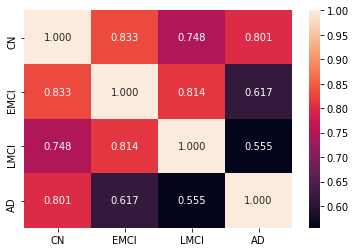

In [68]:
sns.heatmap(mean_corr_adj,
            yticklabels=subjects_groups,
            xticklabels=subjects_groups,
            annot=True, fmt='0.3f')

### Save the notebook